# 1º passo Gerar os dataset's 

• number of instances (rows in your dataset table) Bernardo  (2)

• number of classes (for multi-class classification problems) Ricardo (3)

• proportion of classes (balanced and imbalanced class problem) Ricardo (2)

• distribution of points within each class (shape of point clouds) Ricardo (3)

• shape of the border between the class regions, from linear to whatever Bernardo (3)

• level of noise André (3)

• level of overlap between the classes André (2)


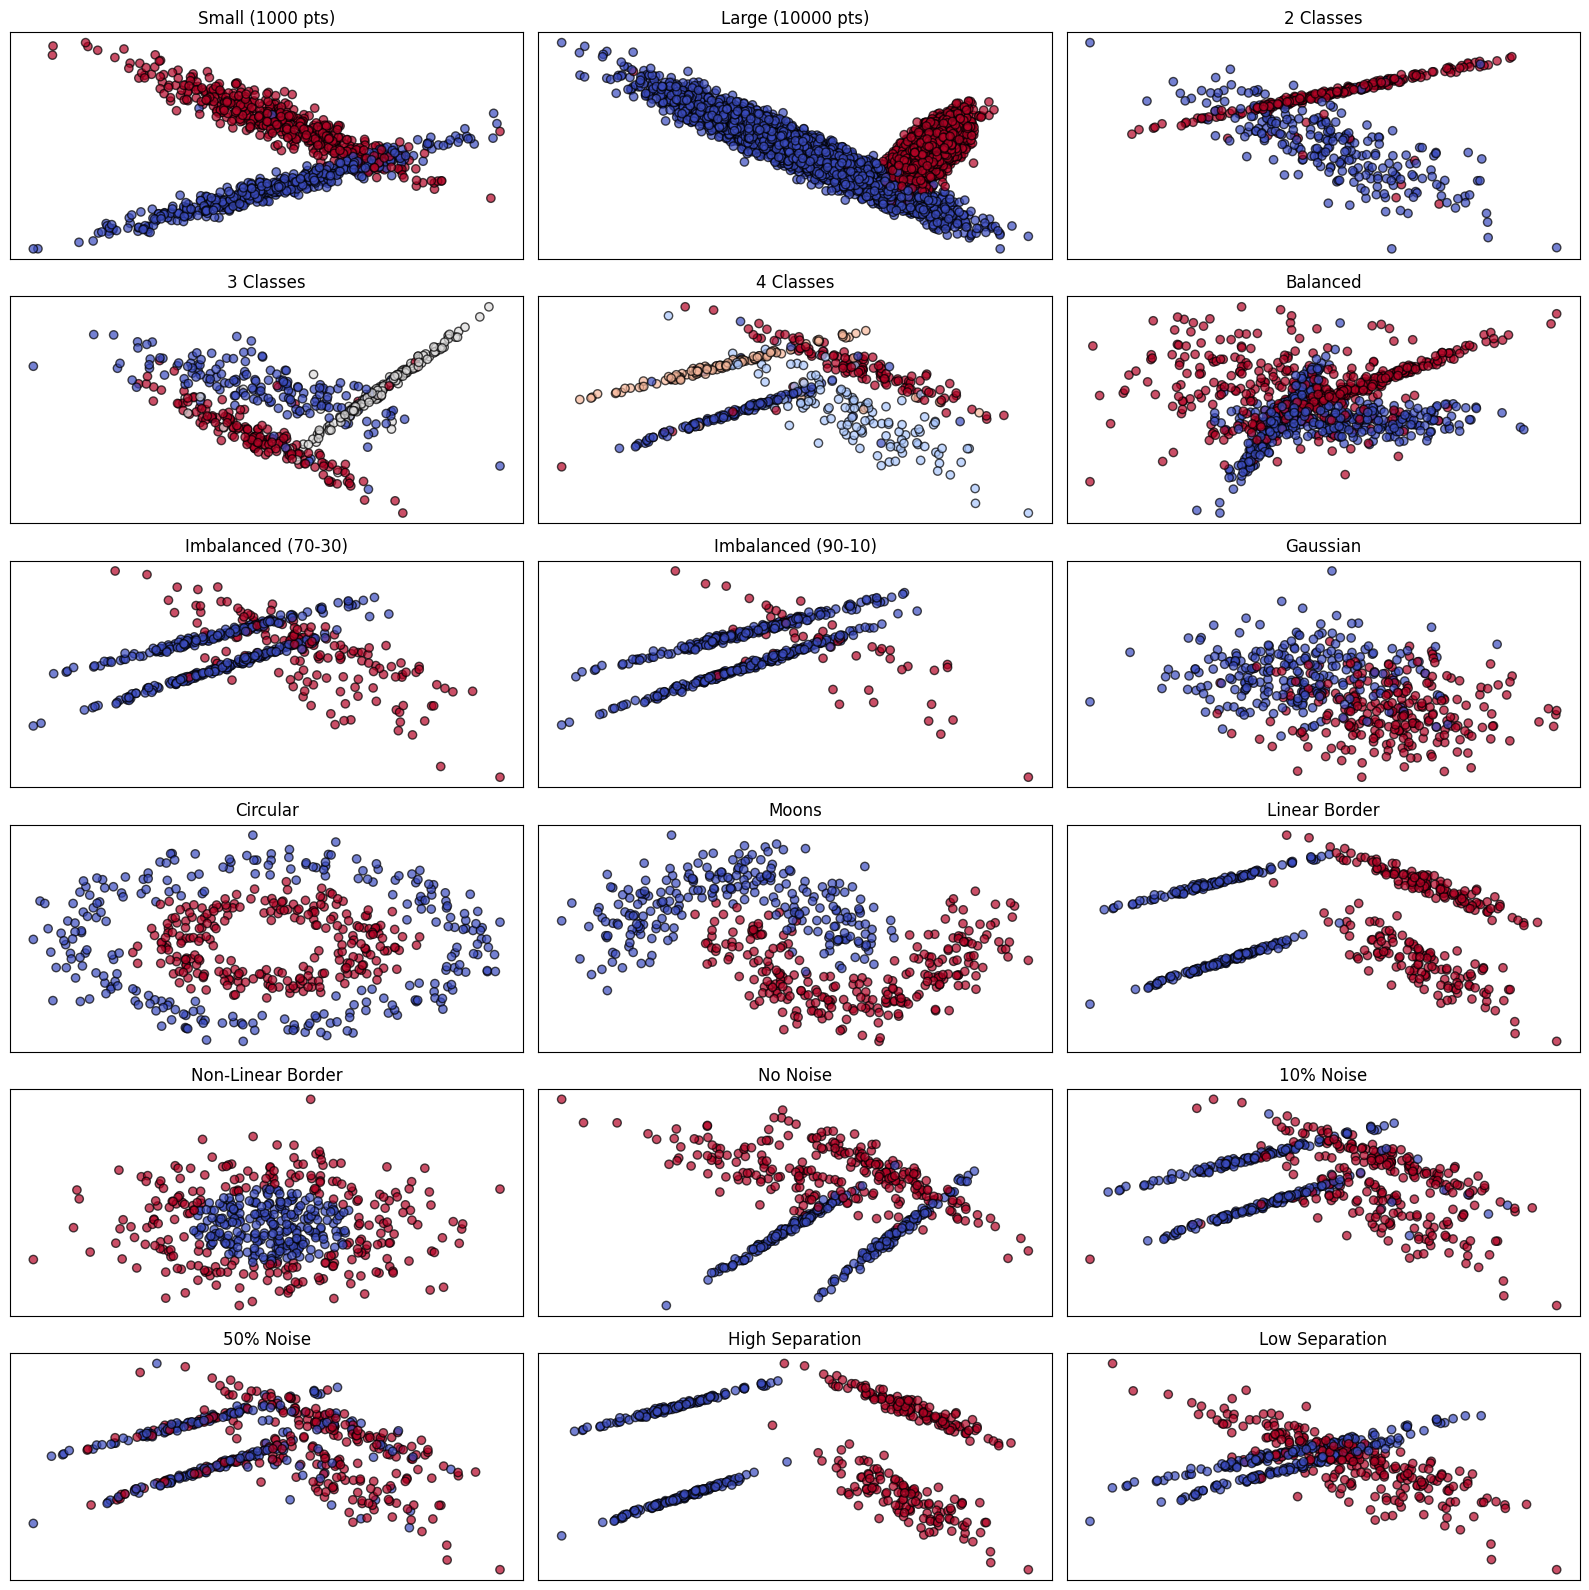

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix)
from sklearn.datasets import make_gaussian_quantiles



# Fixar seed para reprodutibilidade
np.random.seed(42)

# Lista de datasets
datasets = {}

# Número de Samples (pequeno e grande)
datasets["Small (1000 pts)"] = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
datasets["Large (10000 pts)"] = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)

# Número de classes (2, 3 e 4)
datasets["2 Classes"] = make_classification(n_samples=500, n_features=2,shuffle=True, n_informative=2, n_redundant=0, n_clusters_per_class=1,class_sep=1, flip_y=0.1, random_state=42)
datasets["3 Classes"] = make_classification(n_samples=500, n_features=2,shuffle=True, n_informative=2, n_redundant=0, n_clusters_per_class=1,class_sep=1, flip_y=0.1, n_classes=3, random_state=42)
datasets["4 Classes"] = make_classification(n_samples=500, n_features=2,shuffle=True, n_informative=2, n_redundant=0, n_clusters_per_class=1,class_sep=1, flip_y=0.1, n_classes=4, random_state=42)

# Proporção de classes (Balanceado e Desbalanceado)
datasets["Balanced"] = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, weights=[0.5, 0.5], class_sep=0.6, random_state=42)
datasets["Imbalanced (70-30)"] = make_classification(n_samples=500, n_features=2,  n_informative=2, n_redundant=0, weights=[0.7, 0.3], class_sep=0.6, random_state=42)
datasets["Imbalanced (90-10)"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, weights=[0.9, 0.1], class_sep=0.6, random_state=42)

# Distribuição dos pontos (Gaussian, Circular, Moons)
datasets["Gaussian"] = make_blobs(n_samples=500, centers=2, cluster_std=5, random_state=42)
datasets["Circular"] = make_circles(n_samples=500, noise=0.1, factor=0.5, random_state=42)
datasets["Moons"] = make_moons(n_samples=500, noise=0.2, random_state=42)

# Forma da fronteira (Linear vs. Não Linear)
datasets["Linear Border"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, class_sep=2.0, random_state=42)
datasets["Non-Linear Border"] = make_gaussian_quantiles(mean=[0, 0],cov=3.0,n_samples=500,n_features=2,n_classes=2,random_state=42)

# Nível de Ruído (0, 10%, 30%)
datasets["No Noise"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, flip_y=0.0, random_state=42)
datasets["10% Noise"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, flip_y=0.1, random_state=42)
datasets["50% Noise"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, flip_y=0.5, random_state=42)

# Sobreposição entre classes (Separação alta vs. baixa)
datasets["High Separation"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, class_sep=2.5, random_state=42)
datasets["Low Separation"] = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, class_sep=0.3, random_state=42)

# 📊 Visualizar os datasets
fig, axes = plt.subplots(6, 3, figsize=(16, 16))
for ax, (name, (X, y)) in zip(axes.flatten(), datasets.items()):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor='k', alpha=0.7)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Separar datasets em treino e teste
datasets_train_test = {name: train_test_split(X, y, test_size=0.3, random_state=42) for name, (X, y) in datasets.items()}


 

Análise dos modelos nos datasets

In [136]:
import time


# Classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Decision Tree (depth=2)": DecisionTreeClassifier(max_depth=2),
    "Logistic Regression": LogisticRegression(),
    "LDA": LDA(),
    "QDA": QDA(),
    "SVM (linear)": SVC(kernel='linear', probability=True),
    "SVM (rbf)": SVC(kernel='rbf', probability=True)
}

# Function to plot decision boundaries for all models
def plot_decision_boundaries(models, X_test, y_test, dataset_name):
    fig, axes = plt.subplots(1, len(models), figsize=(20, 4))
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    
    for ax, (name, model) in zip(axes, models.items()):
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        ax.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="coolwarm", edgecolor='k', alpha=0.7)
        ax.set_title(name)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(f"Decision Boundaries - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Função para plotar todas as curvas ROC no mesmo gráfico (não multiclass)
def plot_roc_curves(models, X_test, y_test, y_preds, dataset_name):
    if len(np.unique(y_test)) > 2:  # Verifica se o dataset é multiclass
        print(f"⚠️ Skipping ROC Curve (Multiclass detected) for {dataset_name}")
        return

    plt.figure(figsize=(6, 6))

    # Agora, calculamos e plote as curvas ROC
    for name, y_score in y_preds.items():
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {dataset_name}")
    plt.legend(loc="lower right")
    plt.show()

# Função para plotar todas as matrizes de confusão juntas
def plot_confusion_matrices(models, y_test, y_preds, dataset_name):
    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 4))  # Ajusta tamanho

    # Se houver apenas um modelo, `axes` não é uma lista, então precisamos tratar isso
    if len(models) == 1:
        axes = [axes]

    for ax, (name, model) in zip(axes, models.items()):
        y_pred_cm = y_preds[name]  # Usa o `y_pred` já calculado

        try:
            cm = confusion_matrix(y_test, y_pred_cm)
            sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, ax=ax)
            ax.set_title(name)
            ax.set_xlabel("Predicted")
            ax.set_ylabel("Actual")
        except ValueError as e:
            print(f"⚠️ Erro ao gerar matriz de confusão para {name}: {e}")
            ax.axis("off")  # Esconde o gráfico se houver erro

    plt.suptitle(f"Confusion Matrices - {dataset_name}")
    plt.tight_layout()
    plt.show()

# Definição de hiperparâmetros para cada modelo (somente modelos que suportam tuning)
param_grids = {
    "Decision Tree": {"min_samples_split": [2, 5, 10]},
    "Logistic Regression": {"C": [0.1, 1, 10], "solver": ["liblinear", "lbfgs"]},
    "SVM (linear)": {"C": [0.1, 1, 10]},
    "SVM (rbf)": {"C": [0.1, 1, 10], "gamma": ["scale", "auto"]}
}

def evaluate_dataset(dataset_name, cv_folds=5):
    if dataset_name not in datasets_train_test:
        print(f"❌ Dataset '{dataset_name}' not found!")
        return

    X_train, X_test, y_train, y_test = datasets_train_test[dataset_name]
    print(f"\n📊 Evaluating Dataset: {dataset_name} (Cross-Validation: {cv_folds}-fold)")

    trained_models = {}
    y_preds={}
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # Train and evaluate all classifiers
    for name, model in classifiers.items():
        print(f"\n🔍 Training {name}...")
        start_time = time.time()

        # Verifica se há hiperparâmetros para este modelo
        if name in param_grids:
            grid_search = GridSearchCV(model, param_grids[name], cv=kf, scoring='accuracy', n_jobs=-1)  # Professora qual métrica devêmos usar??? 
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_
            print(f" Best Params for {name}: {grid_search.best_params_}")
        else:
            best_model = model  # Usa o modelo original caso não haja hiperparâmetros ajustáveis
            best_model.fit(X_train, y_train)

        # Guarda o modelo treinado
        trained_models[name] = best_model

        # Avaliação no conjunto de teste
        y_pred = best_model.predict(X_test)
        y_preds[name] = y_pred

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        end_time = time.time()
        print(f"Processing time: {round(end_time - start_time, 2)} sec")
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

    # Generate plots with trained models
    plot_decision_boundaries(trained_models, X_test, y_test, dataset_name)
    plot_roc_curves(trained_models,X_test, y_test, y_preds ,dataset_name)
    plot_confusion_matrices(trained_models, y_test, y_preds ,dataset_name)



Small (200pts) Vs Large (10000pts)
    


📊 Evaluating Dataset: Small (1000 pts) (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 5}
Processing time: 0.05 sec
Accuracy: 0.9400, Precision: 0.9400, Recall: 0.9400, F1-score: 0.9400

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.9267, Precision: 0.9274, Recall: 0.9267, F1-score: 0.9267

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'lbfgs'}
Processing time: 0.06 sec
Accuracy: 0.8833, Precision: 0.8874, Recall: 0.8833, F1-score: 0.8832

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.8867, Precision: 0.8926, Recall: 0.8867, F1-score: 0.8864

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.9400, Precision: 0.9420, Recall: 0.9400, F1-score: 0.9400

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.13 sec
Accuracy: 0.9133, Precision: 0.9244, Recall: 0.9133, F1-score: 0.9129

🔍 Training SVM (rbf)...


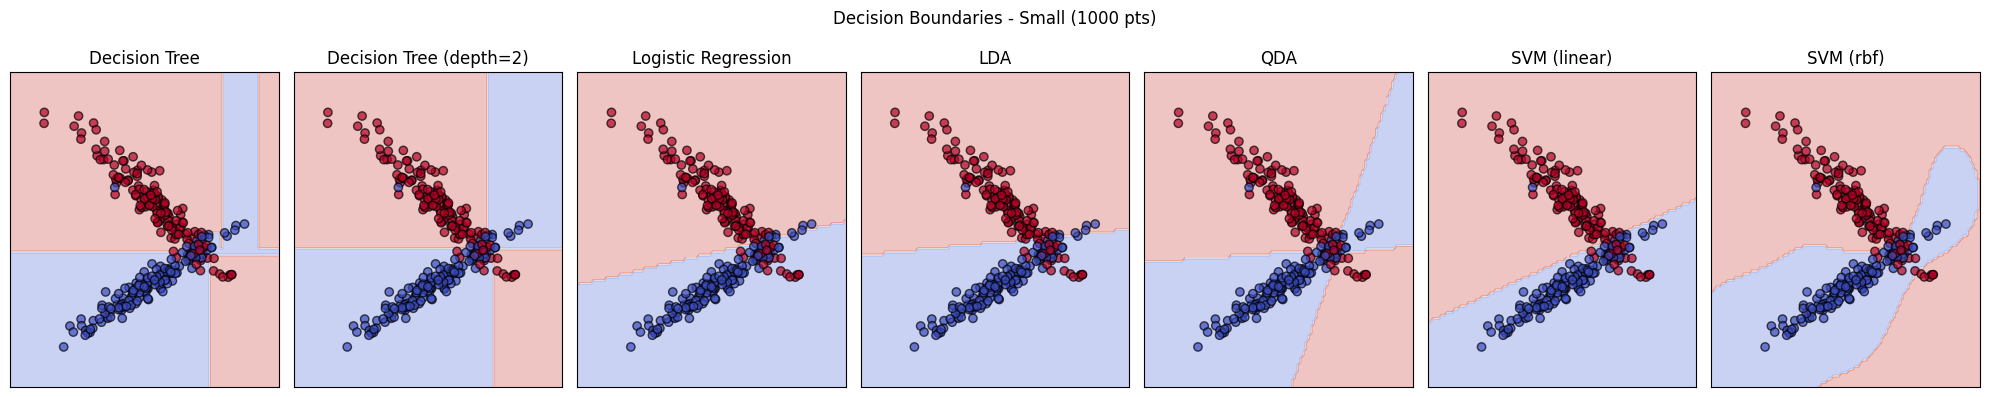

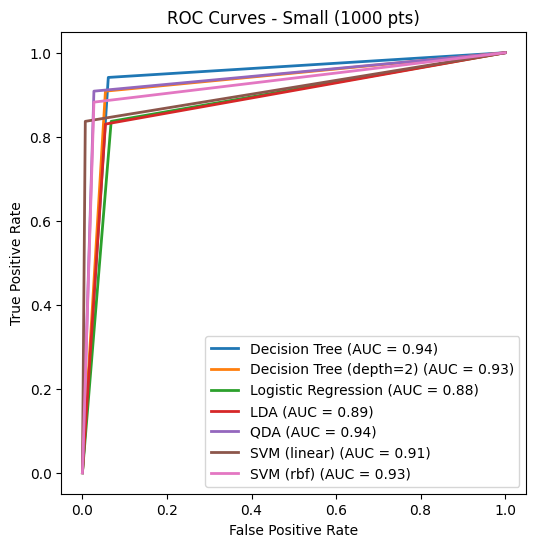

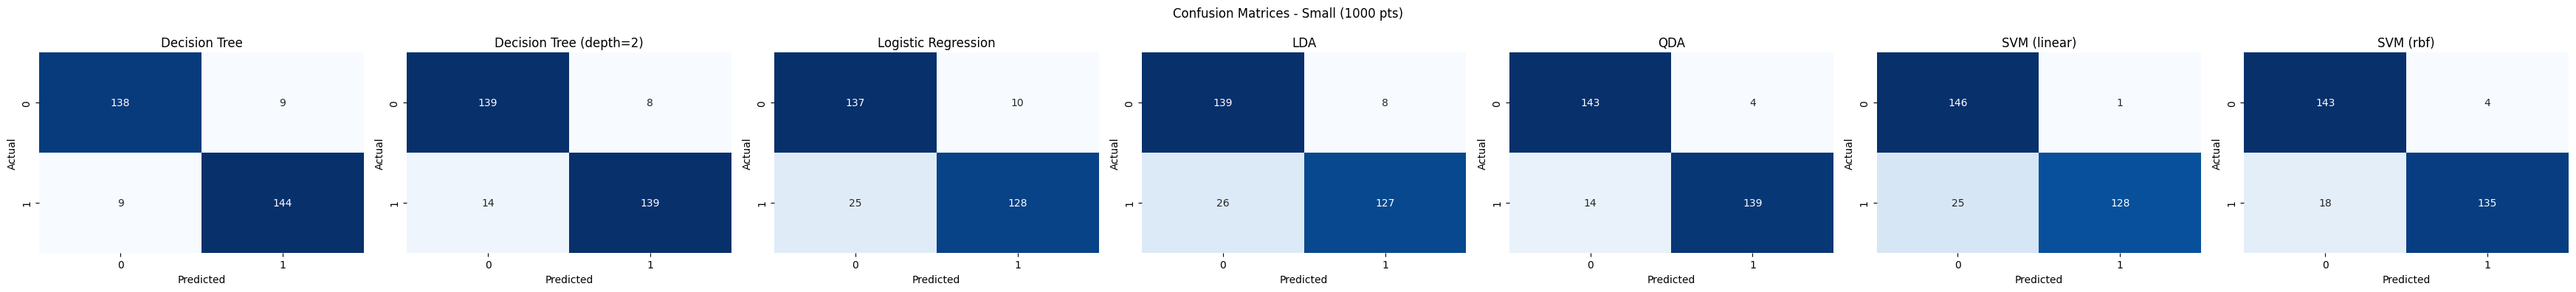


📊 Evaluating Dataset: Large (10000 pts) (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 10}
Processing time: 0.16 sec
Accuracy: 0.9760, Precision: 0.9760, Recall: 0.9760, F1-score: 0.9760

🔍 Training Decision Tree (depth=2)...
Processing time: 0.05 sec
Accuracy: 0.9867, Precision: 0.9867, Recall: 0.9867, F1-score: 0.9867

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Processing time: 0.18 sec
Accuracy: 0.9787, Precision: 0.9787, Recall: 0.9787, F1-score: 0.9787

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.9767, Precision: 0.9768, Recall: 0.9767, F1-score: 0.9767

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.9867, Precision: 0.9867, Recall: 0.9867, F1-score: 0.9867

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 10}
Processing time: 3.37 sec
Accuracy: 0.9797, Precision: 0.9797, Recall: 0.9797, F1-score: 0.9797

🔍 Training SVM (r

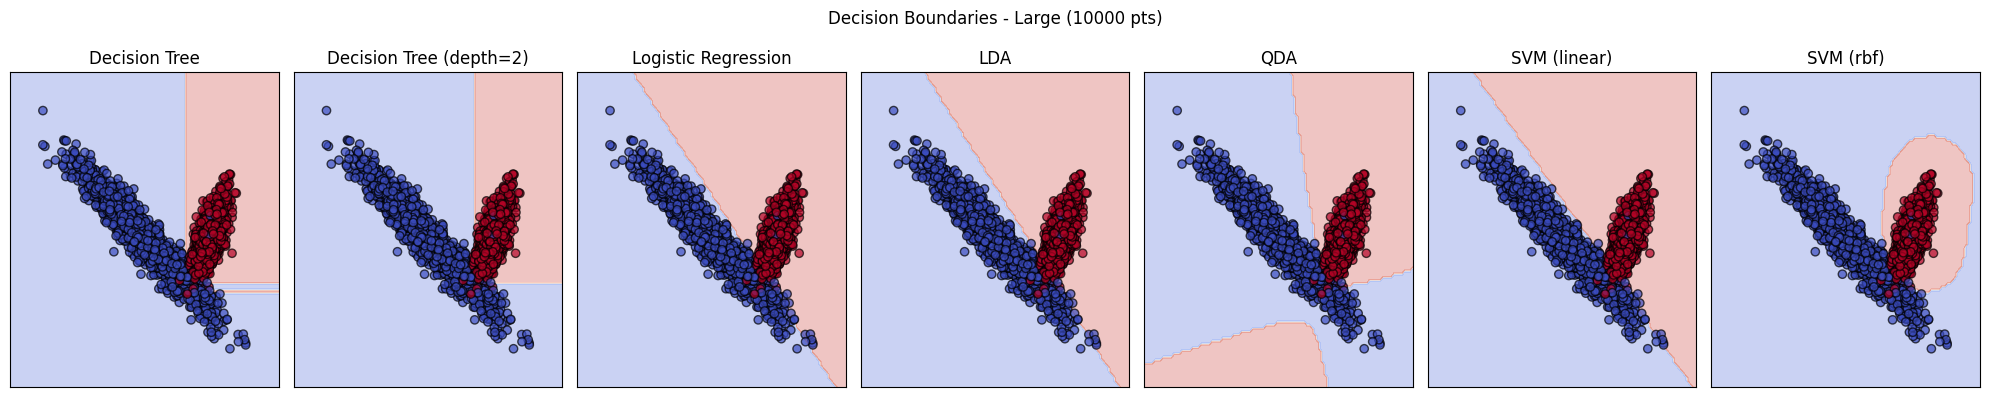

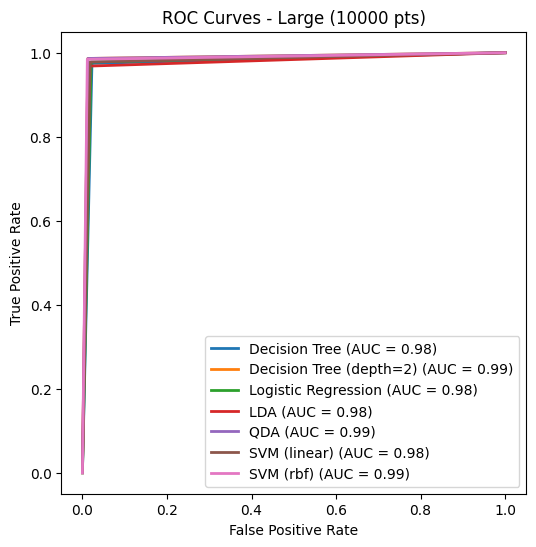

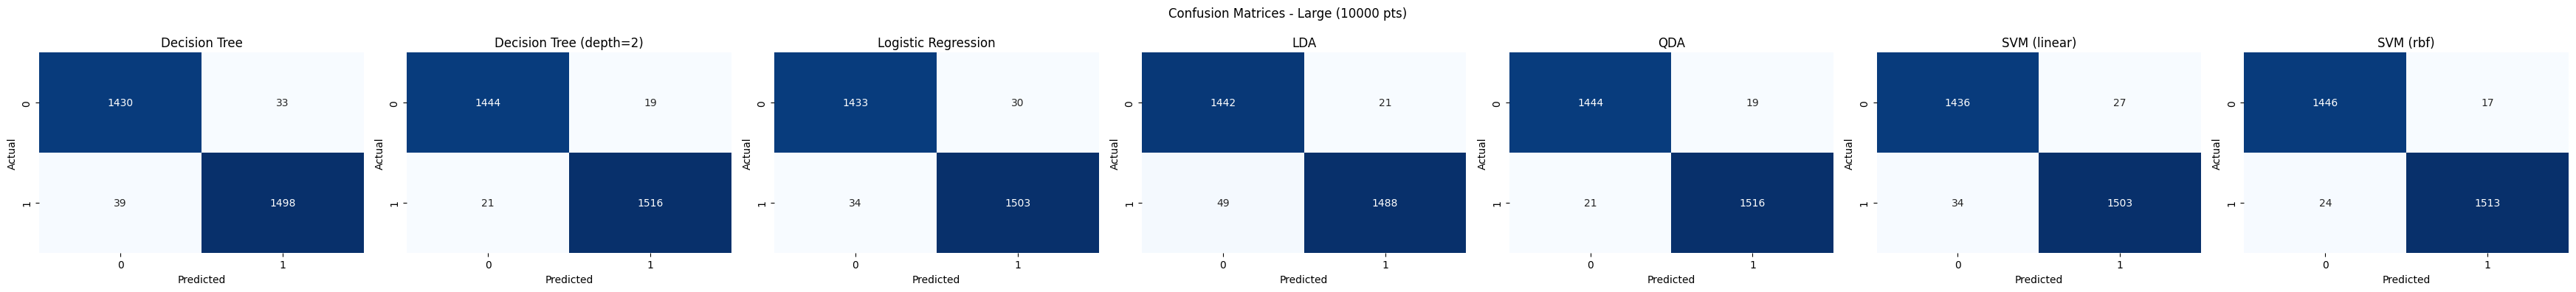

In [137]:
evaluate_dataset("Small (1000 pts)", cv_folds=5)
evaluate_dataset("Large (10000 pts)", cv_folds=5)

Conclusões Principais:
- Todos os modelos melhoraram com o aumento do número de pontos pois tiveram mais exemplos onde treinar
- Inicialemente o algoritmo QDA foi o modelo mais rápido a avaliar o dataset (também o mais preciso) Com o aumentar da dimensão do dataset os algoritmos decisions trees, logistic regression aumentaram ligeiramente o seu tempo de processamento, o QDA e LDA tiveram o menor aumento já o SVM linear e rbf tiveram aumentos na ordem das 100x mostrando alguma dificuldade em lidar com datasets de maiores dimensões
- É importante notar que uma vez que a função make classification dispersa os seus valores seguindo uma distribuição estatistica pseudo-aleatório, entre ambos os datasets analisados não variou apenas o número de amostras mas também ligeiramente o tipo de dispersão obtida o que pode afetar ligeiramente as conclusões retiradas anteriormente


📊 Evaluating Dataset: Low Separation (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 10}
Processing time: 0.07 sec
Accuracy: 0.8400, Precision: 0.8401, Recall: 0.8400, F1-score: 0.8399

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.8200, Precision: 0.8260, Recall: 0.8200, F1-score: 0.8185

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Processing time: 0.06 sec
Accuracy: 0.6667, Precision: 0.6862, Recall: 0.6667, F1-score: 0.6614

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.6733, Precision: 0.6952, Recall: 0.6733, F1-score: 0.6676

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.8867, Precision: 0.9021, Recall: 0.8867, F1-score: 0.8850

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 10}
Processing time: 0.23 sec
Accuracy: 0.6800, Precision: 0.7249, Recall: 0.6800, F1-score: 0.6678

🔍 Training SVM (rbf)

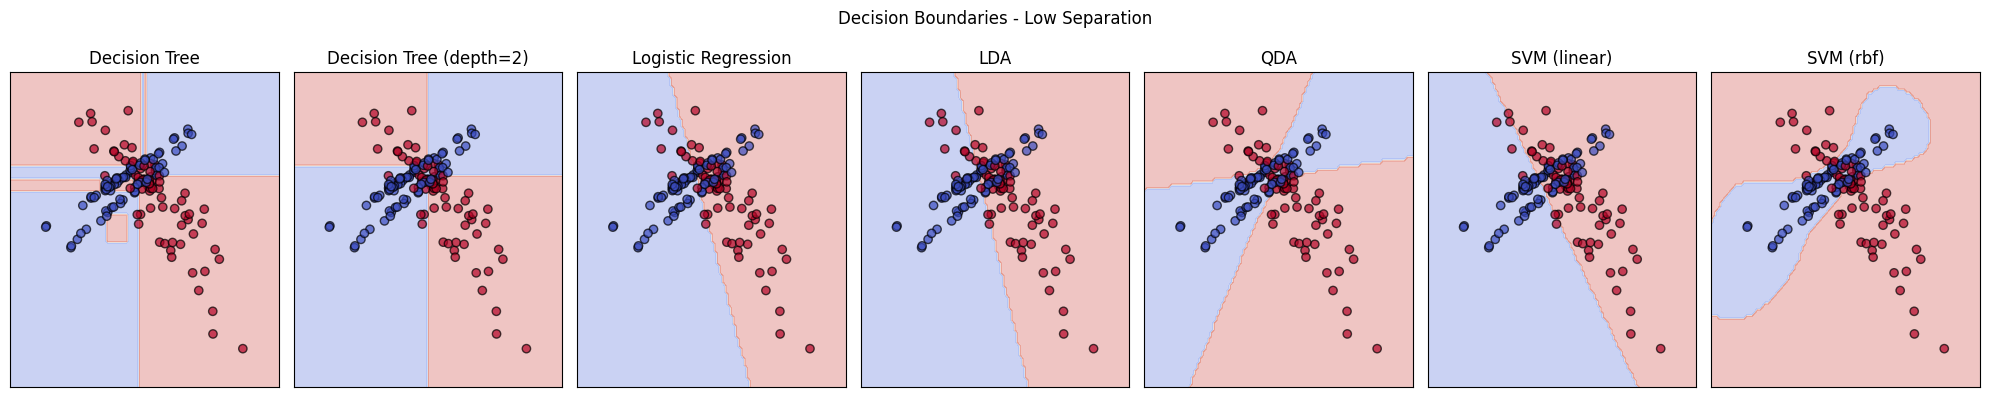

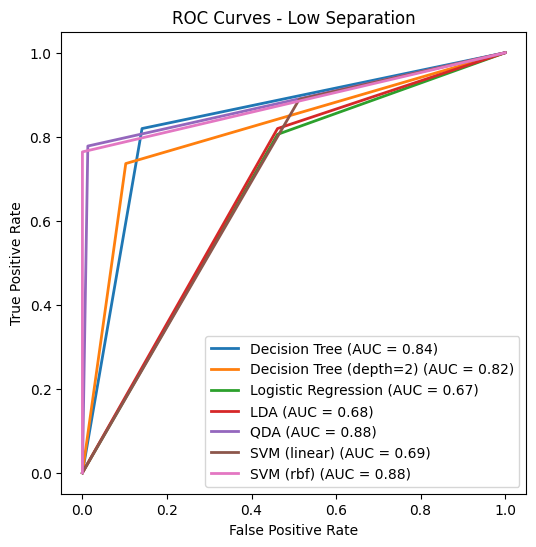

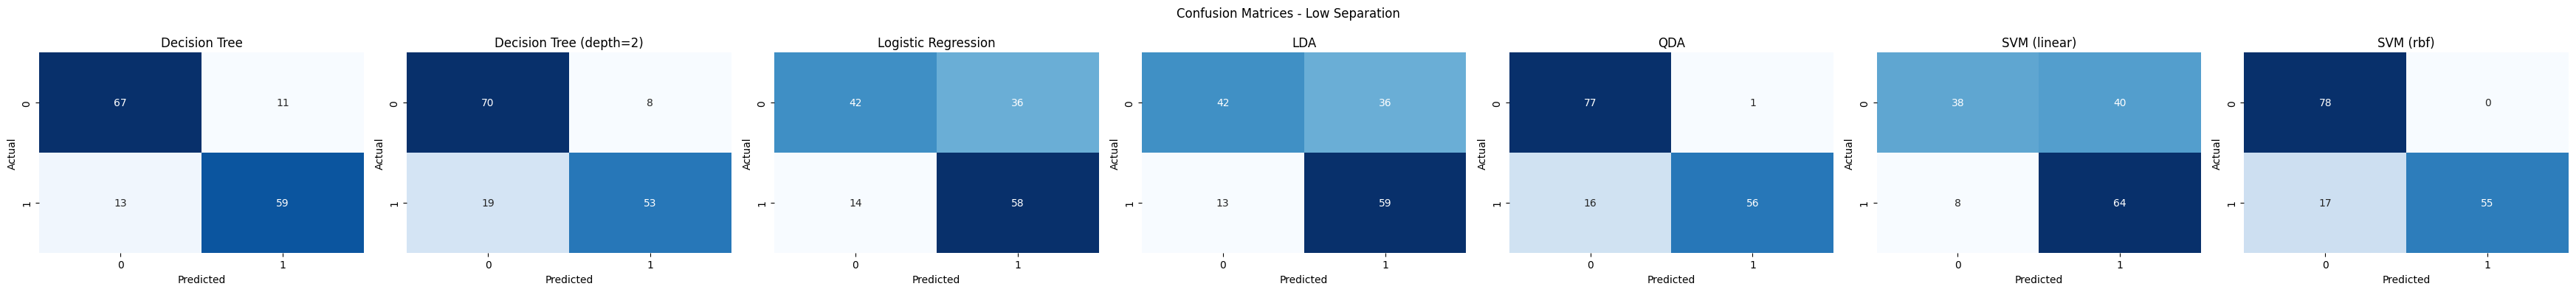

In [138]:

evaluate_dataset("Low Separation")   

# Number of Classes 


📊 Evaluating Dataset: 2 Classes (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 10}
Processing time: 0.04 sec
Accuracy: 0.8600, Precision: 0.8623, Recall: 0.8600, F1-score: 0.8602

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.8800, Precision: 0.8806, Recall: 0.8800, F1-score: 0.8797

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Processing time: 0.49 sec
Accuracy: 0.8333, Precision: 0.8375, Recall: 0.8333, F1-score: 0.8336

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.8133, Precision: 0.8209, Recall: 0.8133, F1-score: 0.8135

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.8600, Precision: 0.8729, Recall: 0.8600, F1-score: 0.8599

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 10}
Processing time: 0.1 sec
Accuracy: 0.8267, Precision: 0.8494, Recall: 0.8267, F1-score: 0.8258

🔍 Training SVM (rbf)...
 B

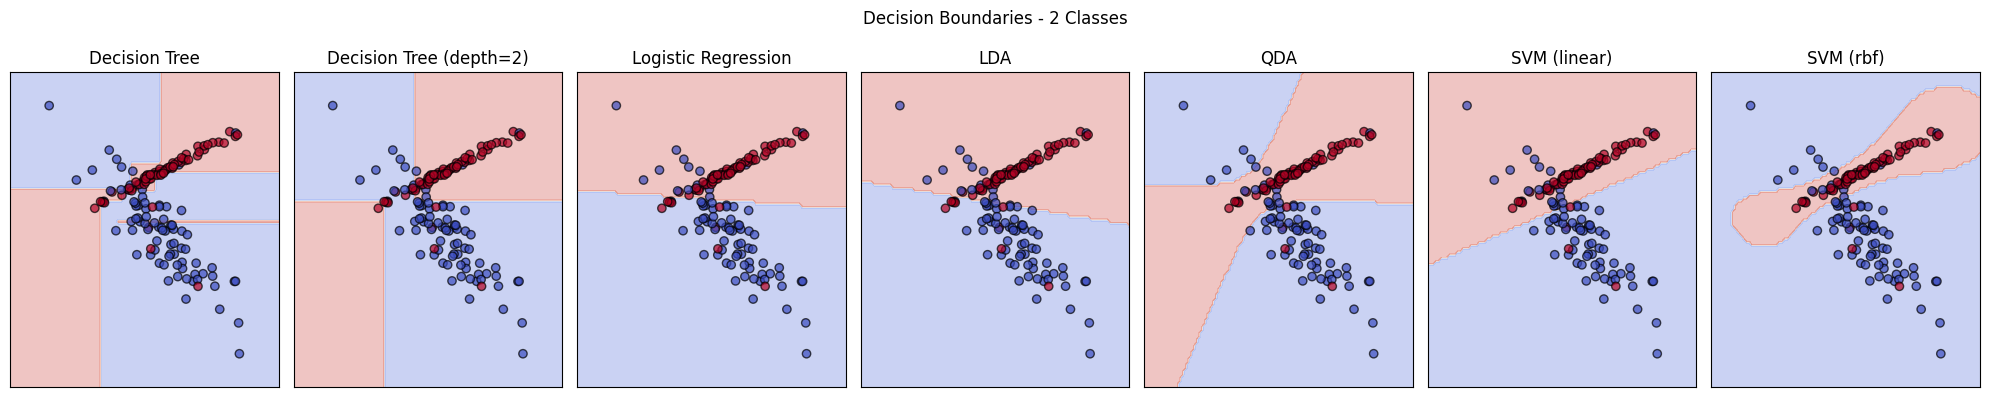

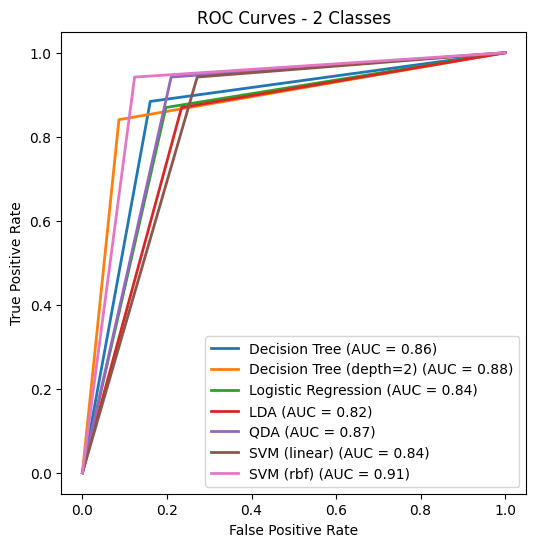

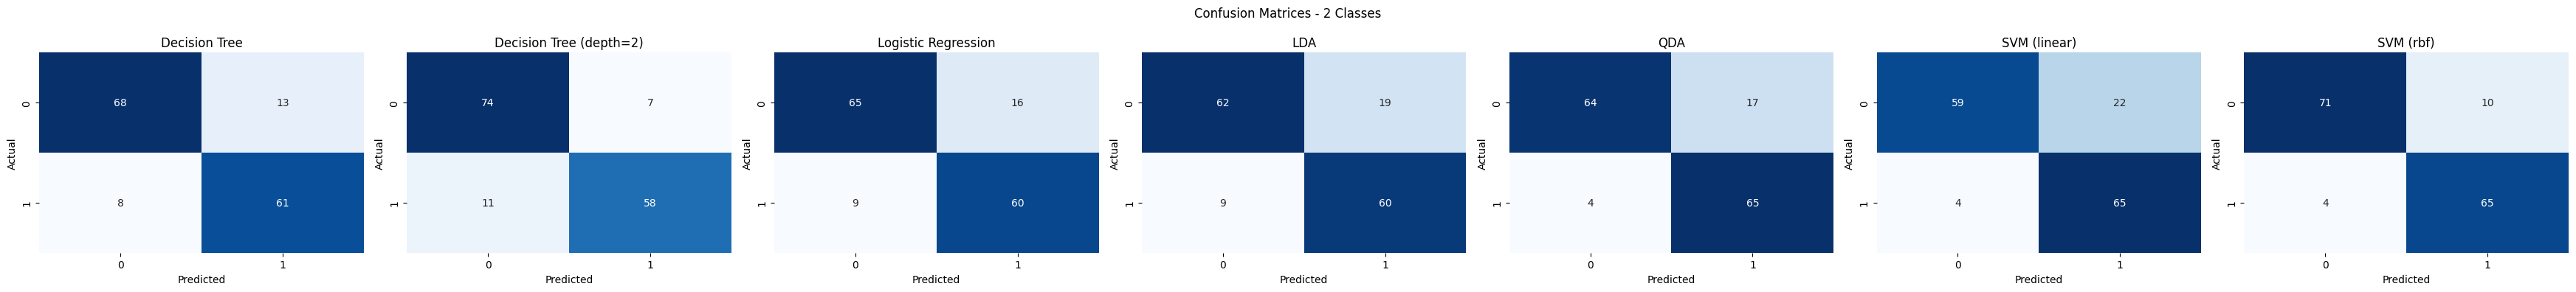

In [139]:
evaluate_dataset("2 Classes")   


📊 Evaluating Dataset: 3 Classes (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 10}
Processing time: 0.08 sec
Accuracy: 0.8267, Precision: 0.8311, Recall: 0.8267, F1-score: 0.8267

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.7600, Precision: 0.7815, Recall: 0.7600, F1-score: 0.7629

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'lbfgs'}
Processing time: 0.12 sec
Accuracy: 0.8467, Precision: 0.8619, Recall: 0.8467, F1-score: 0.8473

🔍 Training LDA...
Processing time: 0.02 sec
Accuracy: 0.8400, Precision: 0.8506, Recall: 0.8400, F1-score: 0.8416

🔍 Training QDA...
Processing time: 0.03 sec
Accuracy: 0.8733, Precision: 0.8864, Recall: 0.8733, F1-score: 0.8738

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 10}
Processing time: 0.26 sec
Accuracy: 0.8533, Precision: 0.8667, Recall: 0.8533, F1-score: 0.8536

🔍 Training SVM (rbf)...
 Best

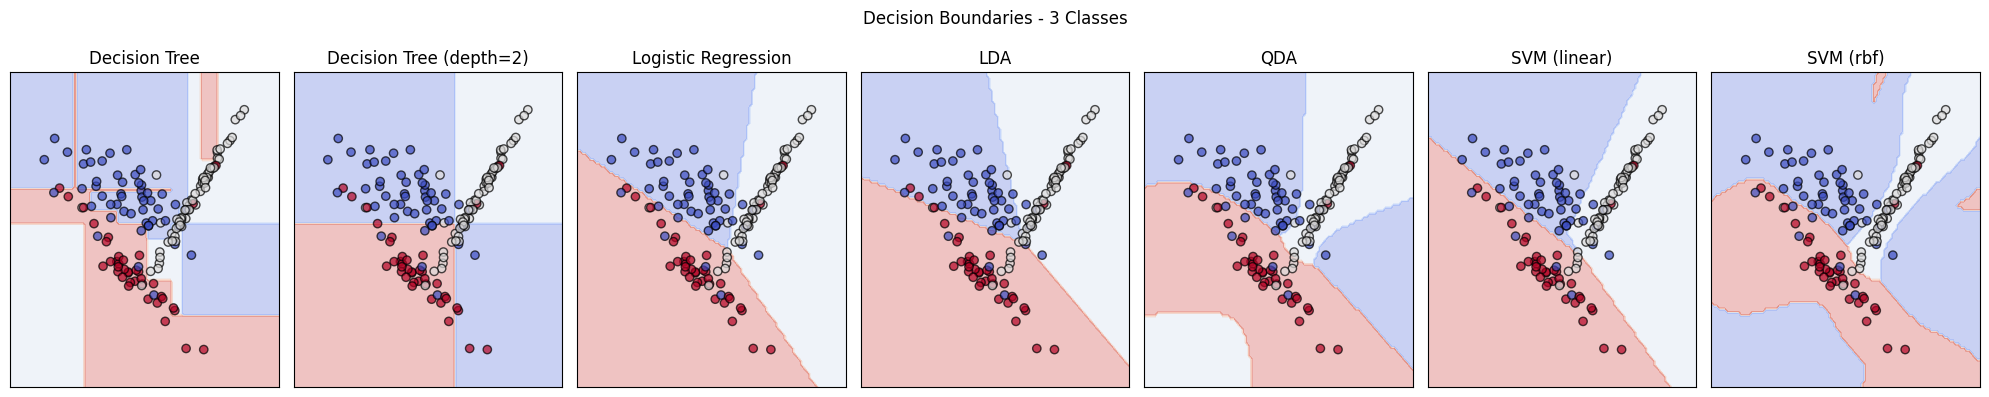

⚠️ Skipping ROC Curve (Multiclass detected) for 3 Classes


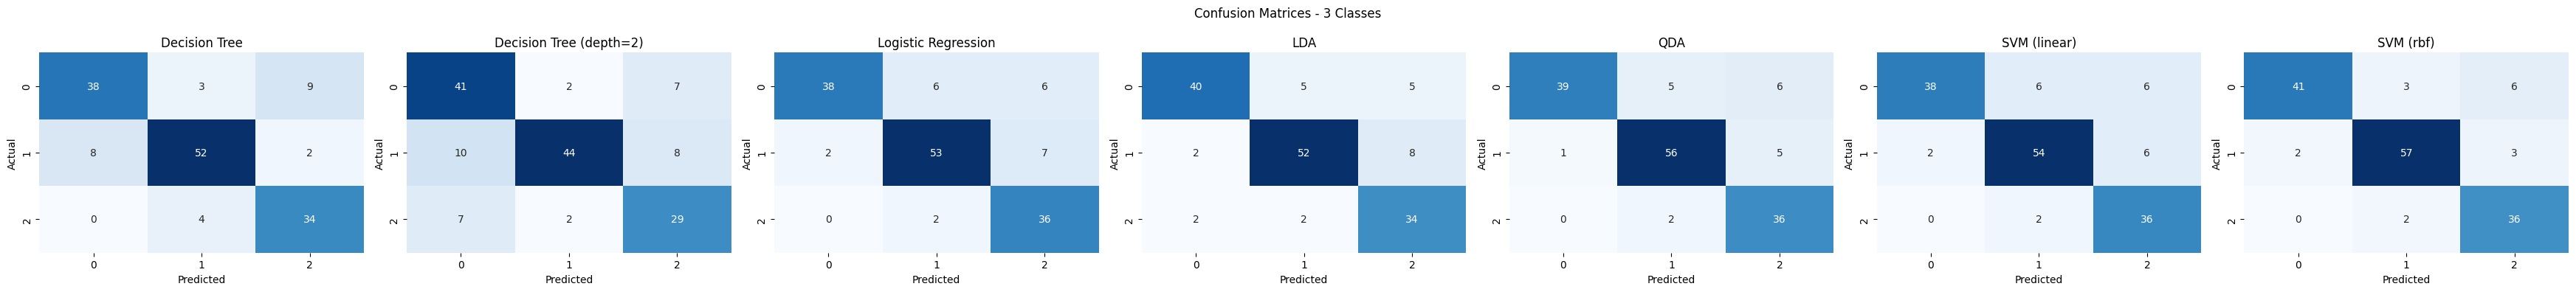

In [140]:
evaluate_dataset("3 Classes")   



📊 Evaluating Dataset: 4 Classes (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 10}
Processing time: 0.06 sec
Accuracy: 0.8200, Precision: 0.8208, Recall: 0.8200, F1-score: 0.8189

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.7000, Precision: 0.7074, Recall: 0.7000, F1-score: 0.7012

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
Processing time: 0.07 sec
Accuracy: 0.7467, Precision: 0.7576, Recall: 0.7467, F1-score: 0.7483

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.6933, Precision: 0.7004, Recall: 0.6933, F1-score: 0.6942

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.8400, Precision: 0.8459, Recall: 0.8400, F1-score: 0.8399

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.28 sec
Accuracy: 0.8067, Precision: 0.8142, Recall: 0.8067, F1-score: 0.8071

🔍 Training SVM (rbf)...
 

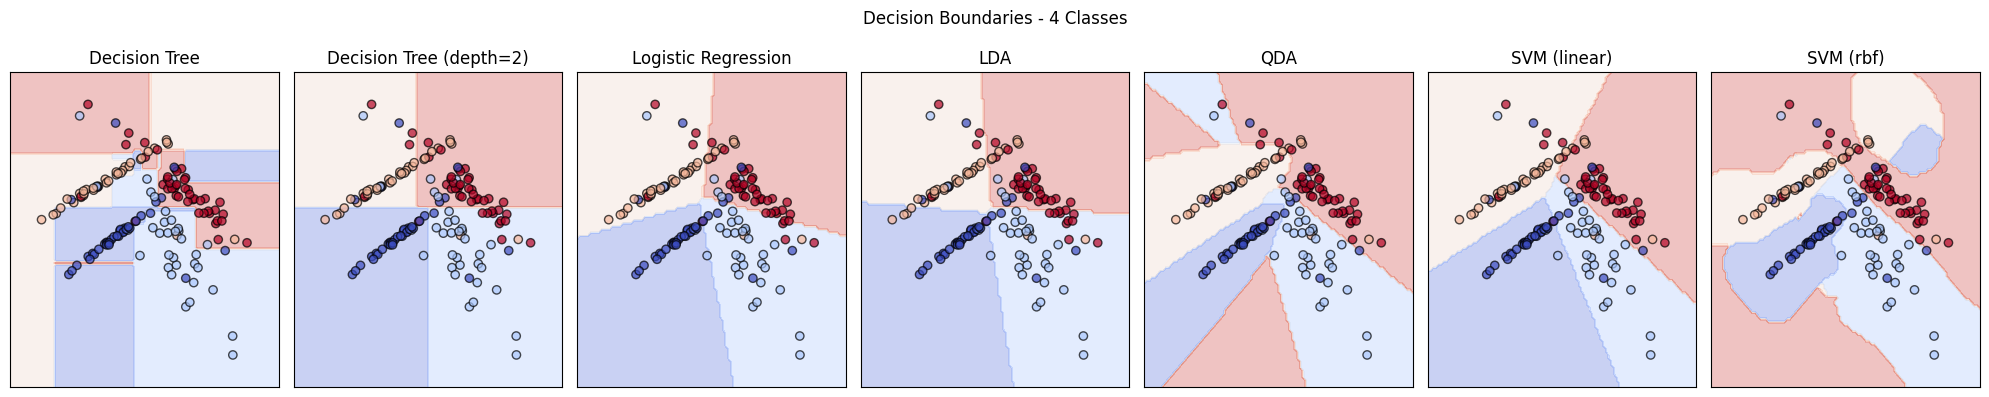

⚠️ Skipping ROC Curve (Multiclass detected) for 4 Classes


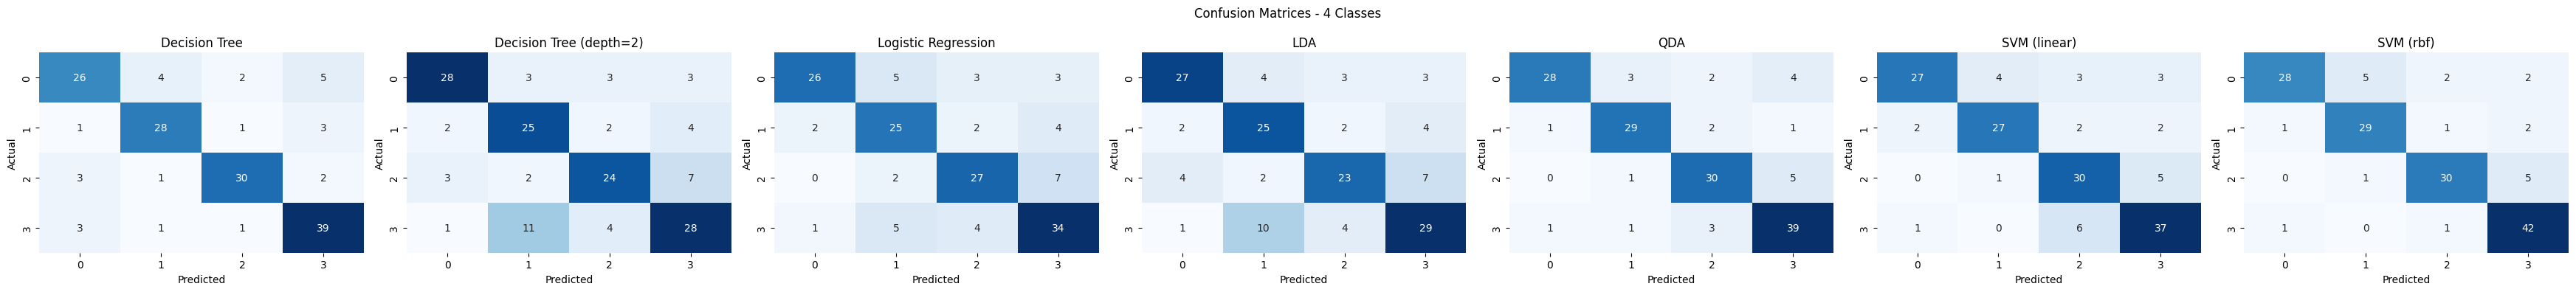

In [141]:
evaluate_dataset("4 Classes")   


 Conclusões Principais:

- O aumento do número de classes reduz a exatidão da maioria dos modelos, pois o problema torna-se mais difícil.
- Modelos não lineares (QDA, SVM RBF) são mais estáveis ao lidar com múltiplas classes.
- Modelos lineares (Regressão Logística, LDA) começam a perder eficiência a partir de 3 classes.
- Árvores de decisão com profundidade limitada podem ajudar a reduzir overfitting, dependendo do número de classes.

# Balance Problem


📊 Evaluating Dataset: Balanced (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 2}
Processing time: 0.07 sec
Accuracy: 0.7900, Precision: 0.7904, Recall: 0.7900, F1-score: 0.7900

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.7933, Precision: 0.8015, Recall: 0.7933, F1-score: 0.7922

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Processing time: 0.06 sec
Accuracy: 0.7833, Precision: 0.7845, Recall: 0.7833, F1-score: 0.7832

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.7833, Precision: 0.7857, Recall: 0.7833, F1-score: 0.7831

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.7467, Precision: 0.7644, Recall: 0.7467, F1-score: 0.7430

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.25 sec
Accuracy: 0.7833, Precision: 0.7857, Recall: 0.7833, F1-score: 0.7831

🔍 Training SVM (rbf)...
 B

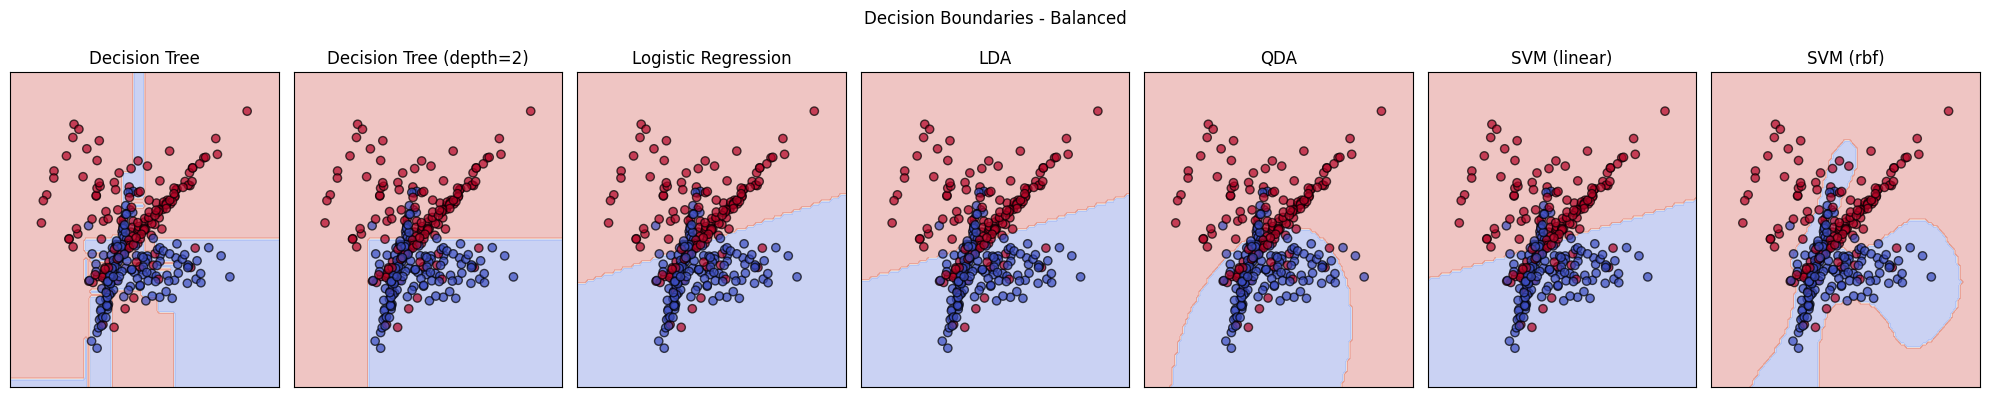

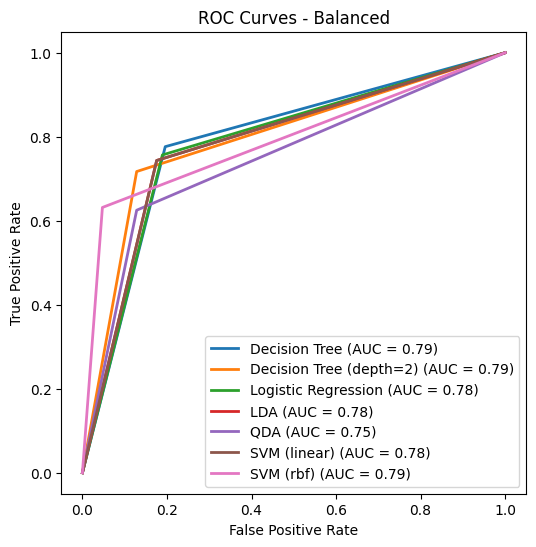

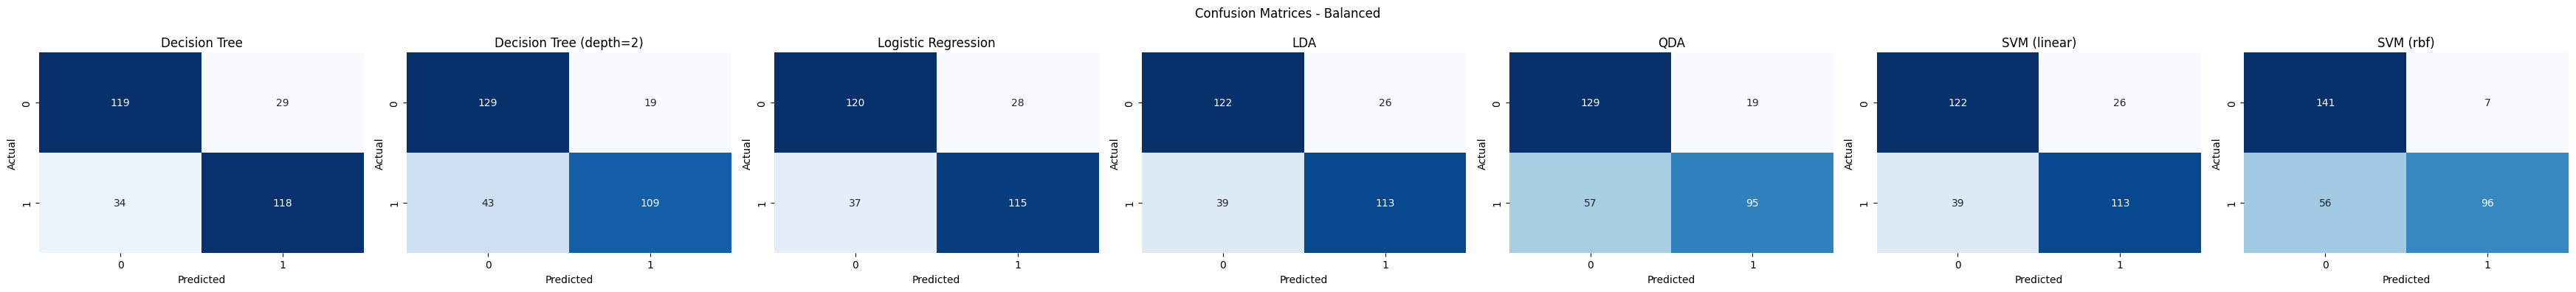

In [142]:
evaluate_dataset("Balanced")   


📊 Evaluating Dataset: Imbalanced (70-30) (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 5}
Processing time: 0.09 sec
Accuracy: 0.8933, Precision: 0.8920, Recall: 0.8933, F1-score: 0.8925

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.8533, Precision: 0.8687, Recall: 0.8533, F1-score: 0.8358

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'lbfgs'}
Processing time: 0.06 sec
Accuracy: 0.8000, Precision: 0.7925, Recall: 0.8000, F1-score: 0.7948

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.8133, Precision: 0.8054, Recall: 0.8133, F1-score: 0.8065

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.8733, Precision: 0.8848, Recall: 0.8733, F1-score: 0.8614

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 0.1}
Processing time: 0.09 sec
Accuracy: 0.8067, Precision: 0.8016, Recall: 0.8067, F1-score: 0.7853

🔍 Training SVM (rbf)

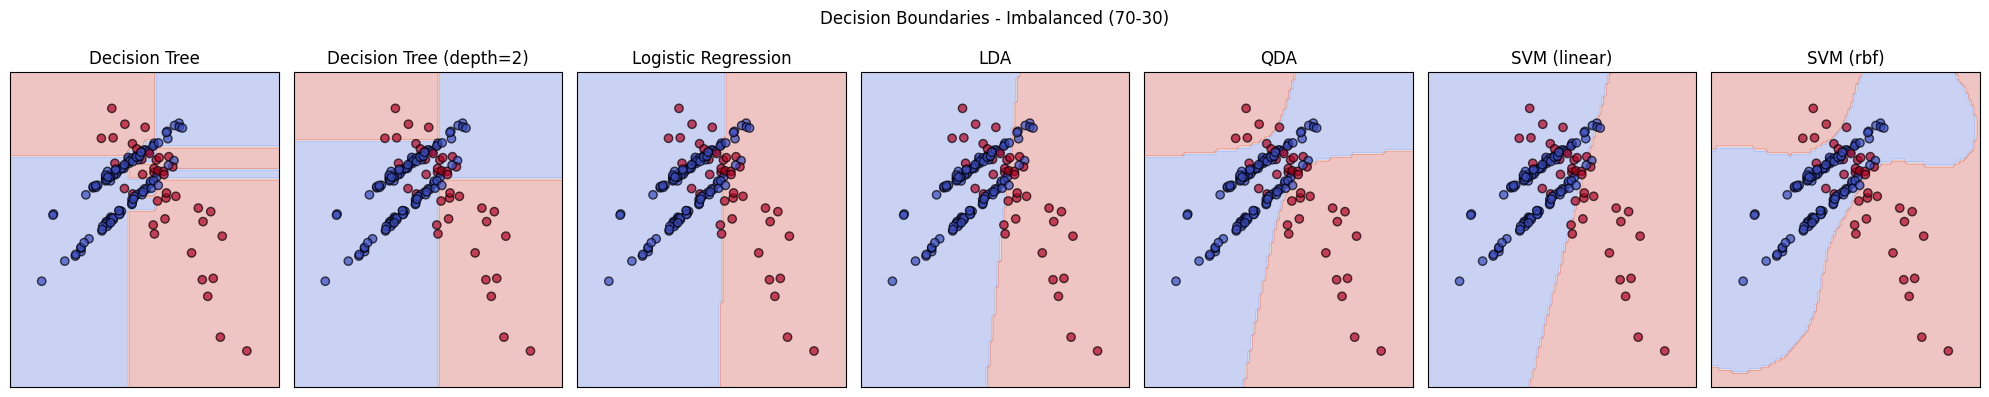

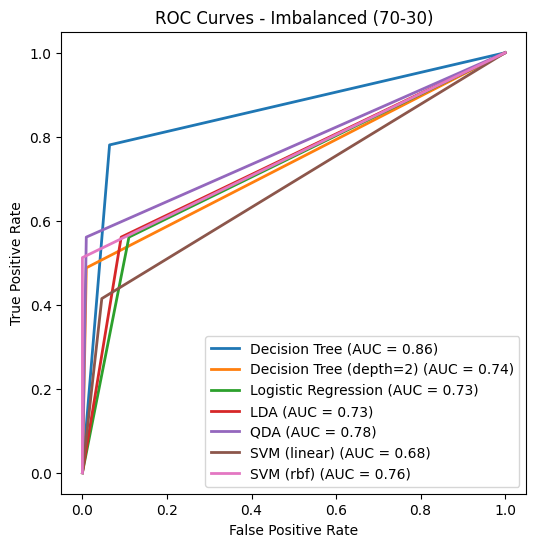

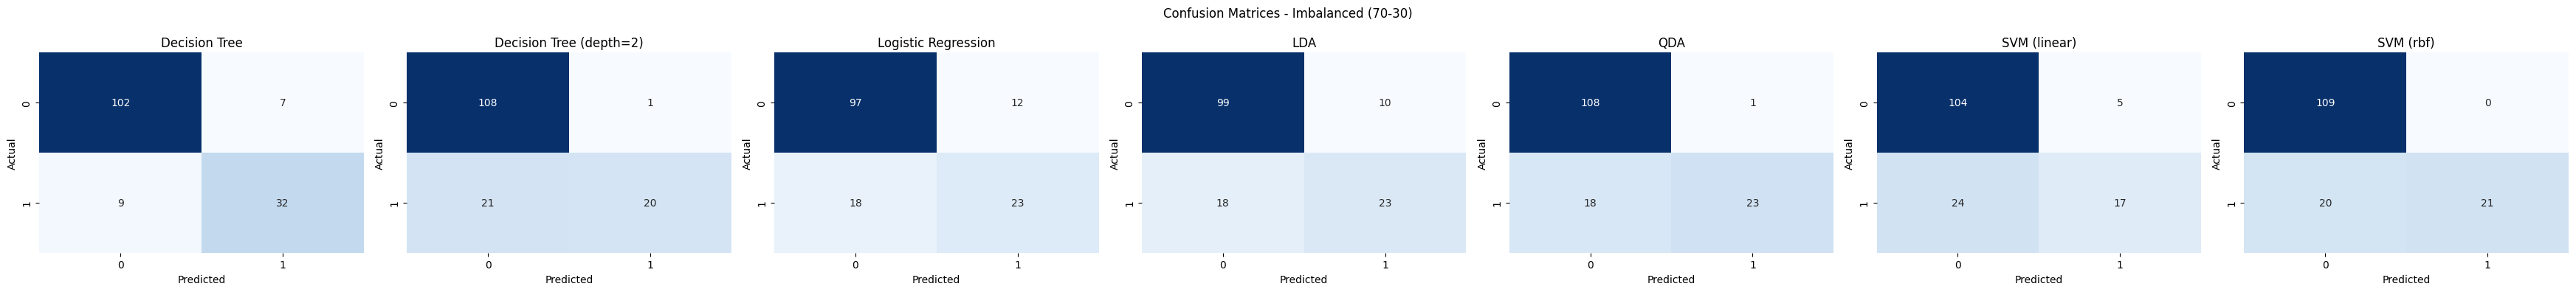

In [143]:
evaluate_dataset("Imbalanced (70-30)") 


📊 Evaluating Dataset: Imbalanced (90-10) (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 2}
Processing time: 0.05 sec
Accuracy: 0.9267, Precision: 0.9295, Recall: 0.9267, F1-score: 0.9280

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.9600, Precision: 0.9576, Recall: 0.9600, F1-score: 0.9563

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Processing time: 0.06 sec
Accuracy: 0.9533, Precision: 0.9556, Recall: 0.9533, F1-score: 0.9443

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.9533, Precision: 0.9556, Recall: 0.9533, F1-score: 0.9443

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.9600, Precision: 0.9617, Recall: 0.9600, F1-score: 0.9538

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.06 sec
Accuracy: 0.9533, Precision: 0.9556, Recall: 0.9533, F1-score: 0.9443

🔍 Training SVM (rbf)

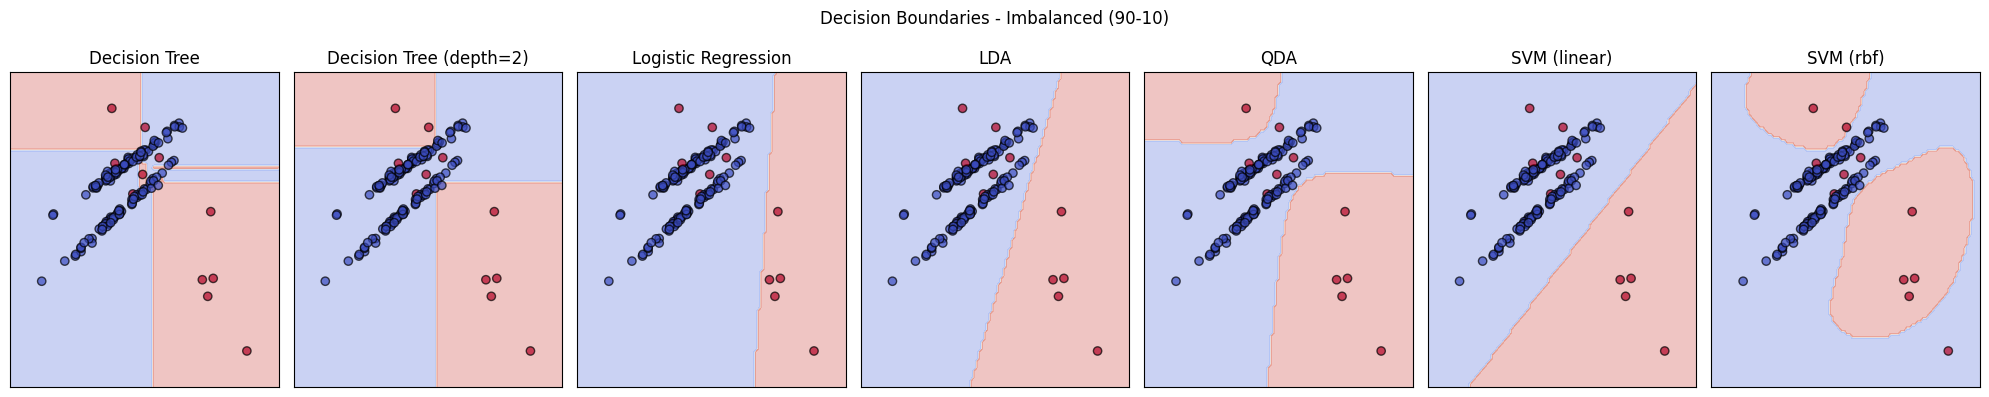

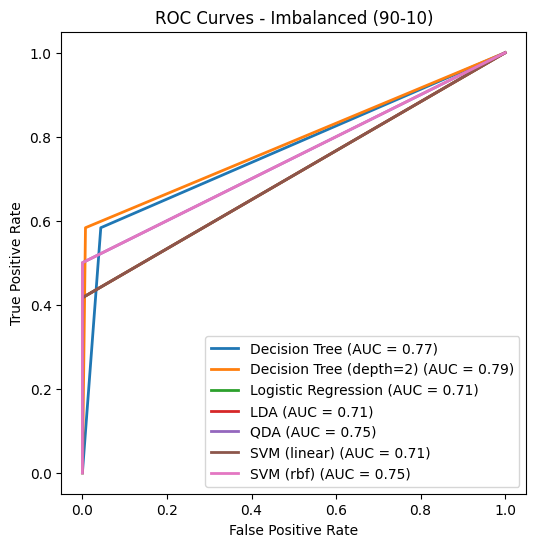

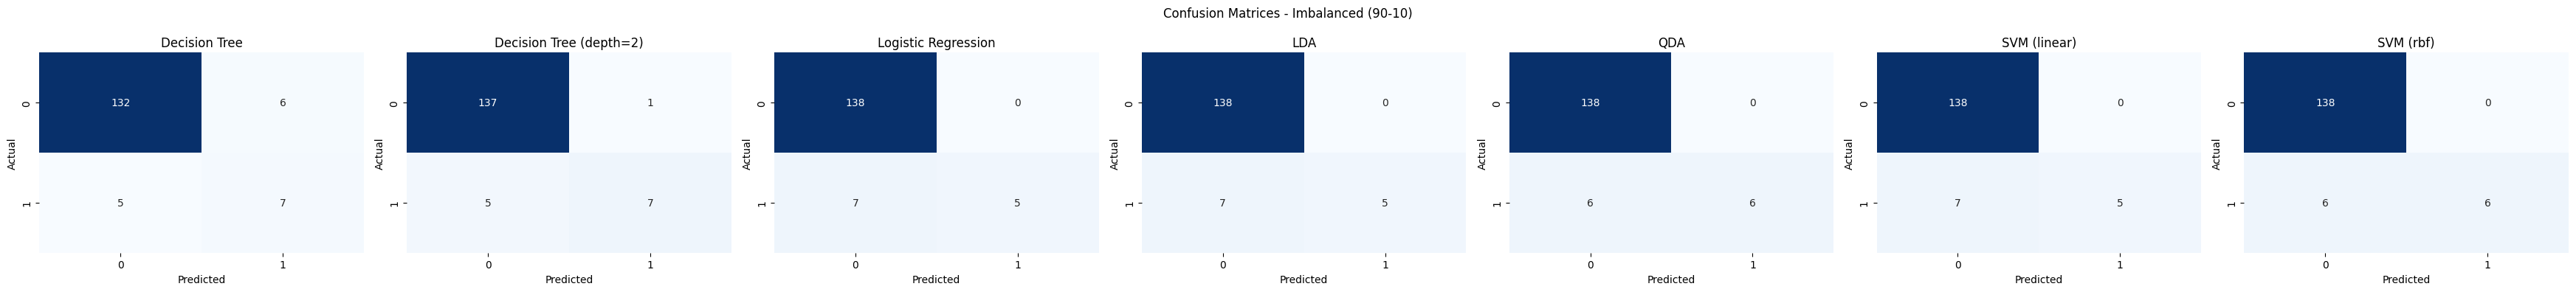

In [144]:
evaluate_dataset("Imbalanced (90-10)") 

Robustez de Modelos ao Desbalanceamento:
Modelos como QDA e SVM (RBF) demonstraram ser mais robustos ao desbalanceamento, mantendo desempenho estável e AUC-ROC apenas ligeiramente afetado. O QDA, em particular, apresentou uma diminuição mínima no AUC-ROC de 0,84 para 0,83, indicando que o modelo tem uma boa capacidade de lidar com datasets desbalanceados, provavelmente devido à sua flexibilidade na modelagem das distribuições de classe.
Árvore de Decisão também teve um desempenho favorável com o aumento do desbalanceamento, especialmente quando utilizada com profundidades menores, o que pode indicar que a estrutura hierárquica da árvore ajuda a identificar a classe minoritária mesmo em contextos desbalanceados.

Dificuldades em Modelos de Separação Linear:
Modelos como Regressão Logística e SVM Linear sofreram uma queda no F1-score, o que se reflete em dificuldades em lidar com datasets desbalanceados. Isso é esperado, pois esses modelos dependem de separações lineares que podem não ser eficazes quando as classes estão desbalanceadas. Esses modelos podem ter dificuldades significativas em identificar corretamente a classe minoritária, o que é evidenciado pela baixa previsão dessa classe nas matrizes de confusão.

Classe Minoritária Desprezada em Matrizes de Confusão:
Uma análise detalhada das matrizes de confusão mostrou que, em datasets desbalanceados, a classe minoritária foi largamente negligenciada por diversos modelos, com muitos falsos negativos e poucos acertos. Esse fenômeno é um indicativo de que os modelos estão tendo dificuldades em capturar corretamente a classe minoritária, resultando em um desempenho prejudicado, especialmente em cenários onde a precisão da classe minoritária é crucial.

AUC-ROC e Impacto no Desbalanceamento:
A métrica AUC-ROC foi essencial para avaliar o desempenho dos modelos em cenários desbalanceados. Enquanto o QDA manteve um desempenho quase constante, outros modelos sofreram uma queda mais acentuada no AUC-ROC, refletindo a dificuldade de alguns algoritmos em lidar com o desbalanceamento. Isso destaca a importância de considerar AUC-ROC e PR AUC em vez de apenas métricas como precisão ou F1-score, especialmente em datasets desbalanceados.


# Distribution of points (shape of point clouds)


📊 Evaluating Dataset: Gaussian (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 5}
Processing time: 0.05 sec
Accuracy: 0.7667, Precision: 0.7775, Recall: 0.7667, F1-score: 0.7663

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.8600, Precision: 0.8622, Recall: 0.8600, F1-score: 0.8602

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Processing time: 0.07 sec
Accuracy: 0.8667, Precision: 0.8682, Recall: 0.8667, F1-score: 0.8668

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.8800, Precision: 0.8805, Recall: 0.8800, F1-score: 0.8801

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.8667, Precision: 0.8682, Recall: 0.8667, F1-score: 0.8668

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 0.1}
Processing time: 0.29 sec
Accuracy: 0.8733, Precision: 0.8735, Recall: 0.8733, F1-score: 0.8734

🔍 Training SVM (rbf)...


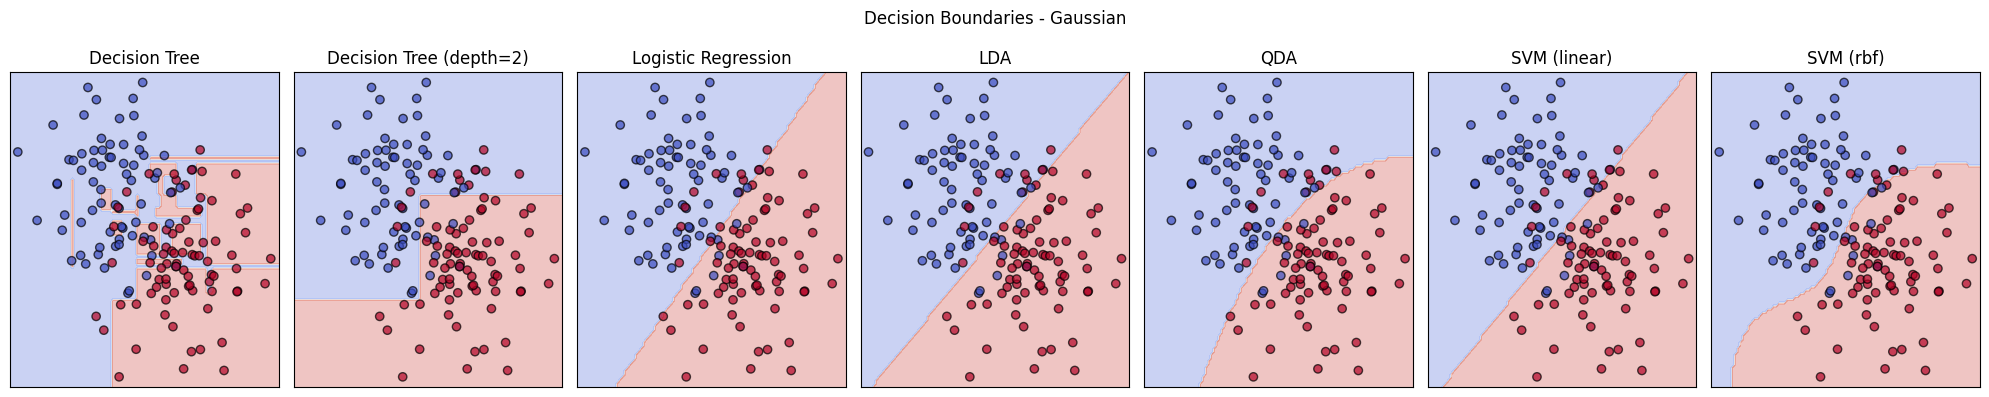

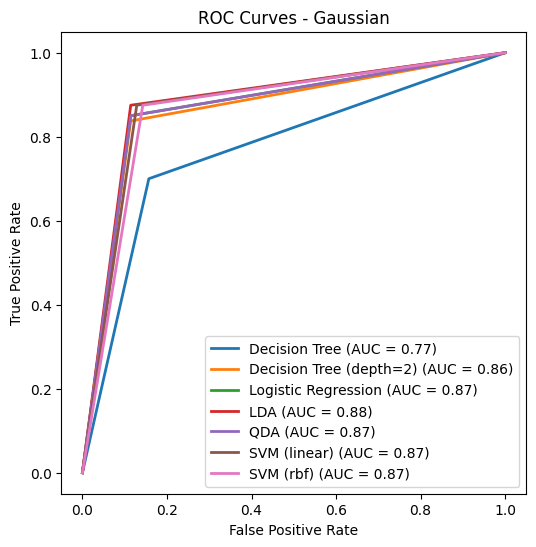

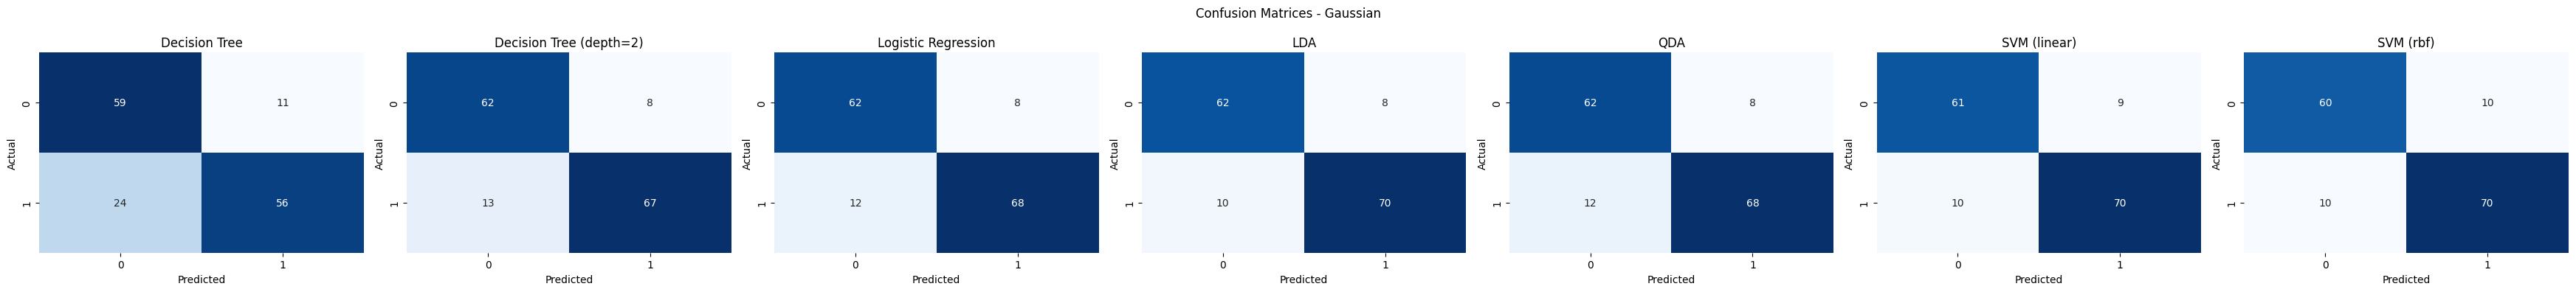

In [145]:
evaluate_dataset("Gaussian") 

 Gaussian (Distribuição Normal)

 -  Formato: Duas classes distribuídas em torno de médias diferentes, separáveis de forma aproximadamente linear.

 -  Melhores modelos: SVM-RBF (83%), QDA (82%), Logistic Regression (82%).

 -  Decision Tree teve desempenho menor (~77%).

Explicação

- Logistic Regression e LDA funcionaram bem (~82%), pois assumem que os dados podem ser separados por uma linha reta. Como a distribuição é aproximadamente normal e linearmente separável, esses métodos se ajustam bem.

- QDA (82%) superou LDA, pois permite separação quadrática, o que ajuda se as classes não forem perfeitamente lineares.

- Decision Tree teve pior desempenho (~77%) porque fragmenta os dados em retângulos em vez de aprender uma separação suave como os métodos baseados em probabilidades ou margens (ex: SVM). Isso pode gerar uma segmentação subótima em distribuições contínuas.

- SVM-RBF obteve melhor resultado (~83%) porque o kernel pode capturar padrões ligeiramente não lineares na distribuição Gaussiana.


📊 Evaluating Dataset: Circular (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 10}
Processing time: 0.04 sec
Accuracy: 0.9800, Precision: 0.9801, Recall: 0.9800, F1-score: 0.9800

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.7467, Precision: 0.7804, Recall: 0.7467, F1-score: 0.7388

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Processing time: 0.08 sec
Accuracy: 0.4800, Precision: 0.4800, Recall: 0.4800, F1-score: 0.4800

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.4867, Precision: 0.4867, Recall: 0.4867, F1-score: 0.4866

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1-score: 0.9800

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.14 sec
Accuracy: 0.5200, Precision: 0.5207, Recall: 0.5200, F1-score: 0.5158

🔍 Training SVM (rbf)...
 Best

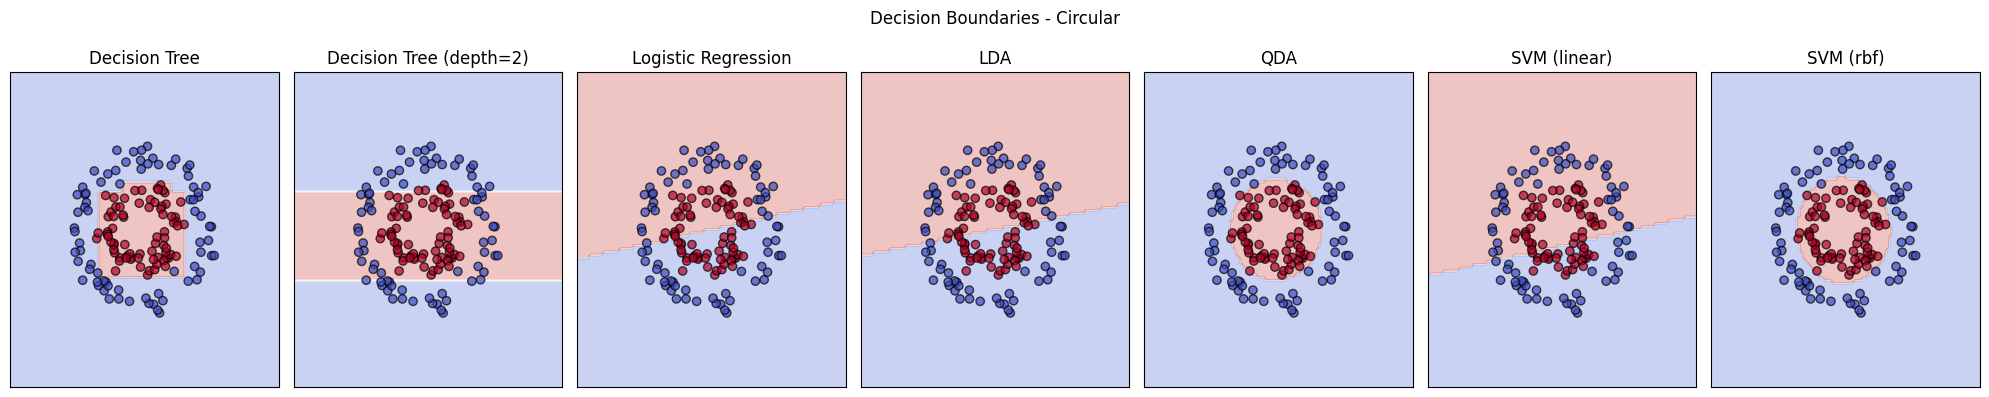

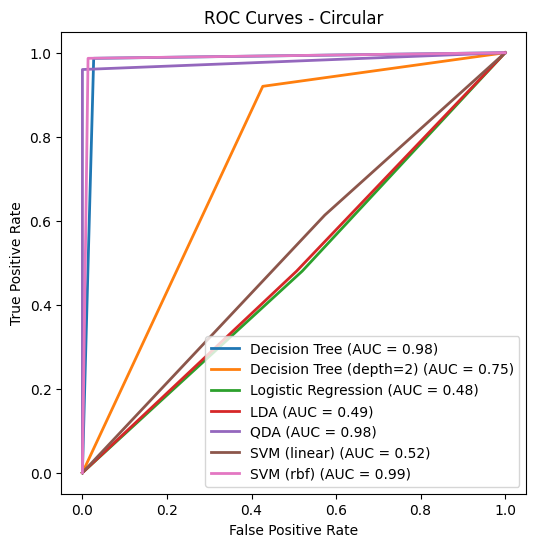

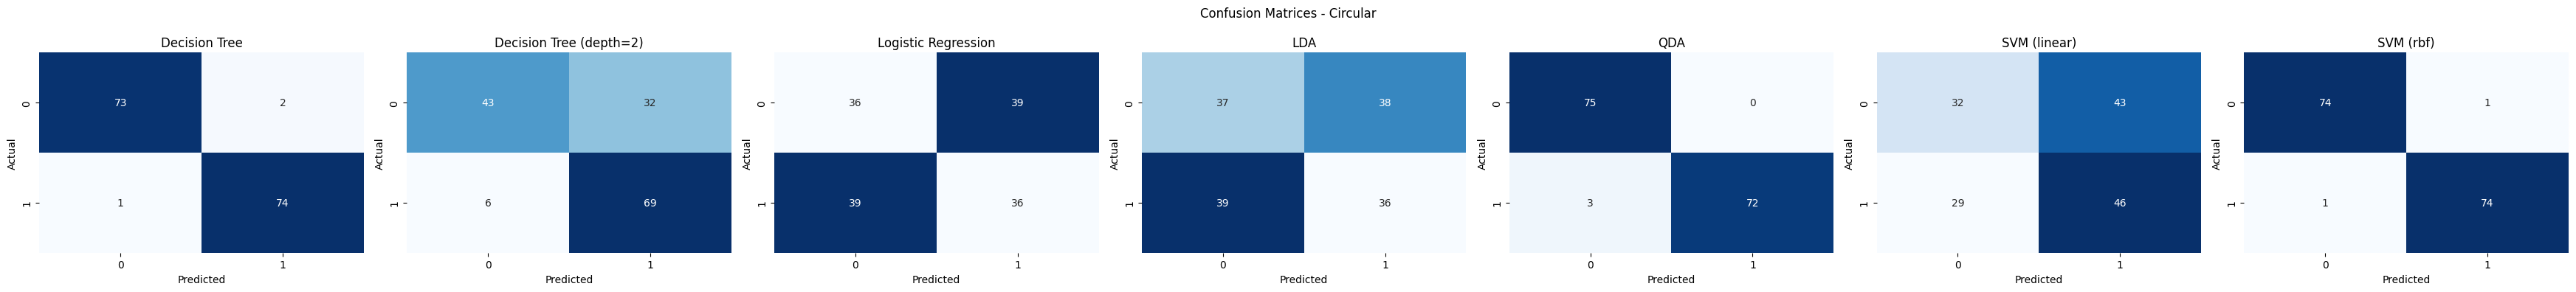

In [146]:
evaluate_dataset("Circular") 

 Circular (Pontos em anéis concêntricos)

   - Formato: Classes dispostas em círculos concêntricos, tornando a separação altamente não linear.

   - Melhores modelos: SVM-RBF (98%), QDA (97%), Decision Tree profunda (94%).

   - Modelos lineares falharam (~47-51%).

 Explicação 

 - Modelos Lineares falharam (~47-51%) porque assumem que as classes podem ser separadas por um hiperplano. Como os dados estão organizados em círculos, um hiperplano não pode capturar essa estrutura.

 - QDA teve excelente desempenho (97%) porque assume que as classes seguem distribuições gaussianas com diferentes matrizes de covariância, permitindo capturar a separação circular.

 - Decision Tree profunda se saiu bem (94%) porque não impõe uma forma fixa à fronteira de decisão, permitindo segmentações arbitrárias nos dados.

 - Decision Tree rasa teve dificuldades (72%), pois uma árvore pouco profunda não consegue capturar a separação circular corretamente.

 - SVM-RBF obteve o melhor resultado (98%) porque o kernel RBF transforma os dados em um espaço dimensional maior onde a separação se torna linear. Como os círculos podem ser separados por uma curva complexa, este modelo se adapta perfeitamente.


📊 Evaluating Dataset: Moons (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 5}
Processing time: 0.04 sec
Accuracy: 0.9667, Precision: 0.9674, Recall: 0.9667, F1-score: 0.9667

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.9133, Precision: 0.9152, Recall: 0.9133, F1-score: 0.9132

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 1, 'solver': 'liblinear'}
Processing time: 0.07 sec
Accuracy: 0.8667, Precision: 0.8677, Recall: 0.8667, F1-score: 0.8666

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.8667, Precision: 0.8677, Recall: 0.8667, F1-score: 0.8666

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.8733, Precision: 0.8739, Recall: 0.8733, F1-score: 0.8733

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.09 sec
Accuracy: 0.8667, Precision: 0.8677, Recall: 0.8667, F1-score: 0.8666

🔍 Training SVM (rbf)...
 Best P

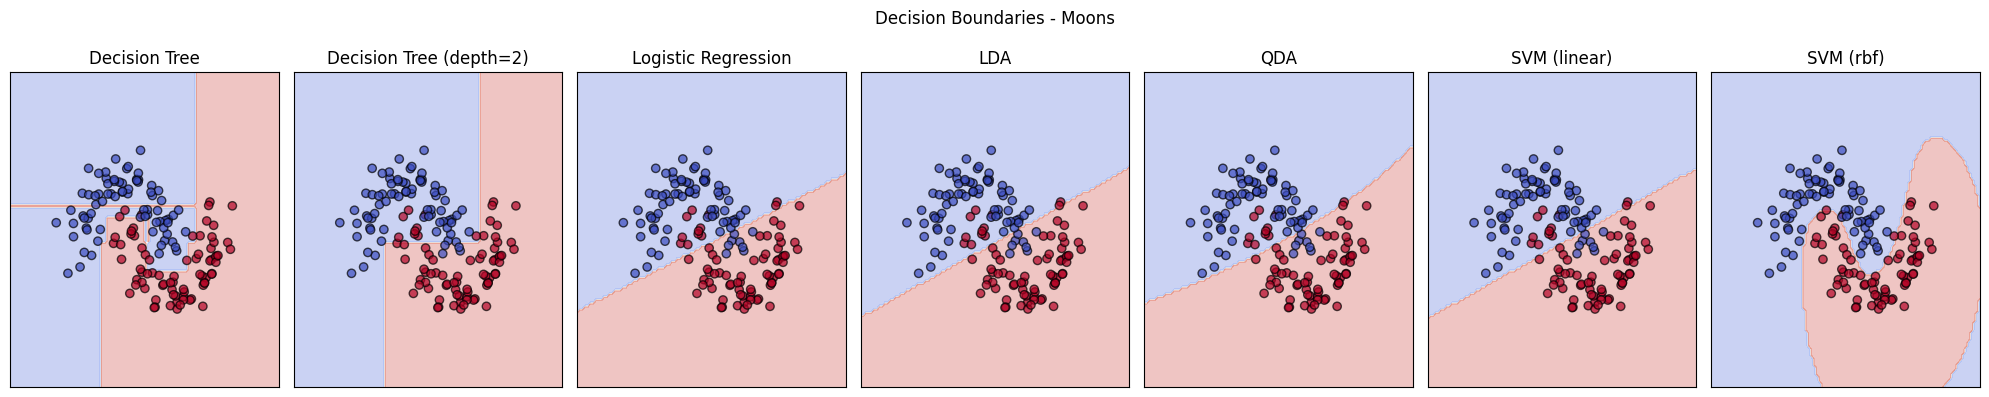

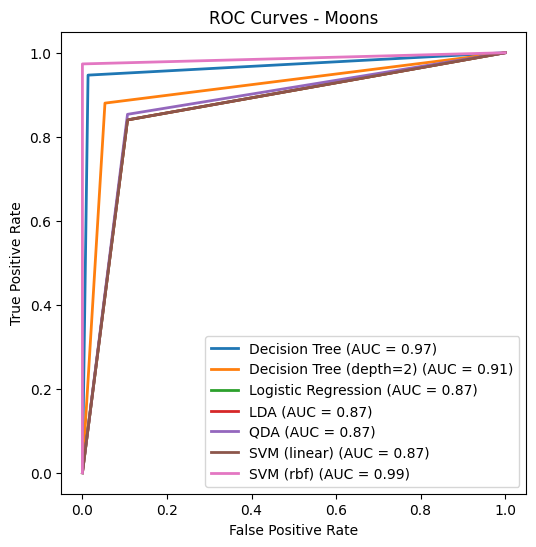

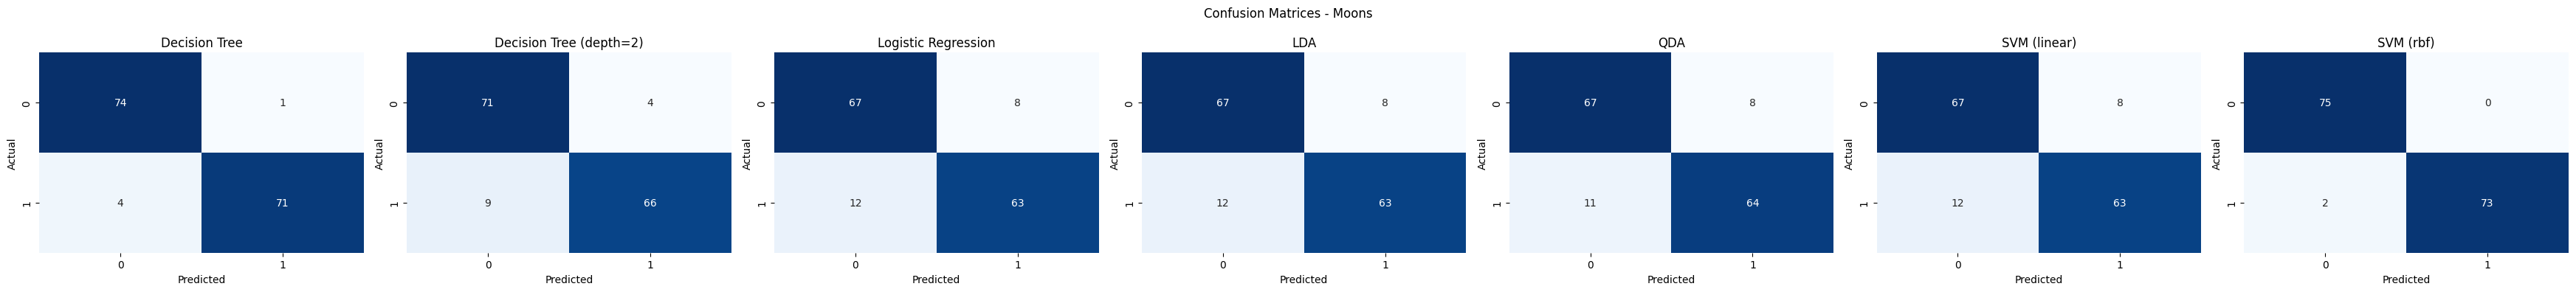

In [147]:
evaluate_dataset("Moons") 

 Moons (Distribuição não linear)

   - Formato: Duas classes dispostas como luas entrelaçadas, não linearmente separáveis.

   - Melhores modelos: SVM-RBF (97%), Decision Tree (96%).

   - Modelos lineares tiveram dificuldades (~85%).

 Explicação 

 - Modelos Lineares (Logistic Regression, LDA, SVM Linear) falharam porque assumem que os dados podem ser separados por uma hiperplano linear. Como a separação entre as classes é curvada, um modelo linear não consegue capturar bem essa fronteira.

 - SVM-RBF teve melhor desempenho porque o kernel RBF permite mapear os dados para um espaço de maior dimensão onde a separação se torna linear. Isso é ideal para distribuições curvadas como Moons.

 - Decision Tree se saiu bem porque não impõe uma forma específica para a fronteira de decisão. Em profundidades maiores, pode capturar padrões complexos como curvas.

 - Decision Tree rasa teve desempenho inferior, pois uma árvore com profundidade limitada não consegue dividir bem a curva dos dados

Conclusões Gerais: 

- Modelos Lineares (Logistic Regression, LDA, SVM Linear) só funcionam bem quando a separação é aproximadamente linear (ex: Gaussian).
- QDA funciona bem para distribuições circulares ou gaussianas, pois assume que cada classe segue uma distribuição normal com diferentes matrizes de covariância.
- Decision Tree se adapta bem a padrões não lineares, mas precisa de profundidade suficiente para capturar fronteiras complexas.
- SVM-RBF foi o mais robusto, pois usa um kernel que transforma os dados em um espaço onde a separação é mais fácil.

Fronteira linear Vs Não Linear 


📊 Evaluating Dataset: Linear Border (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 2}
Processing time: 0.04 sec
Accuracy: 0.9933, Precision: 0.9934, Recall: 0.9933, F1-score: 0.9933

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.9933, Precision: 0.9934, Recall: 0.9933, F1-score: 0.9933

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Processing time: 0.05 sec
Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1-score: 0.9800

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1-score: 0.9800

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.9800, Precision: 0.9808, Recall: 0.9800, F1-score: 0.9800

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.04 sec
Accuracy: 0.9933, Precision: 0.9934, Recall: 0.9933, F1-score: 0.9933

🔍 Training SVM (rbf).

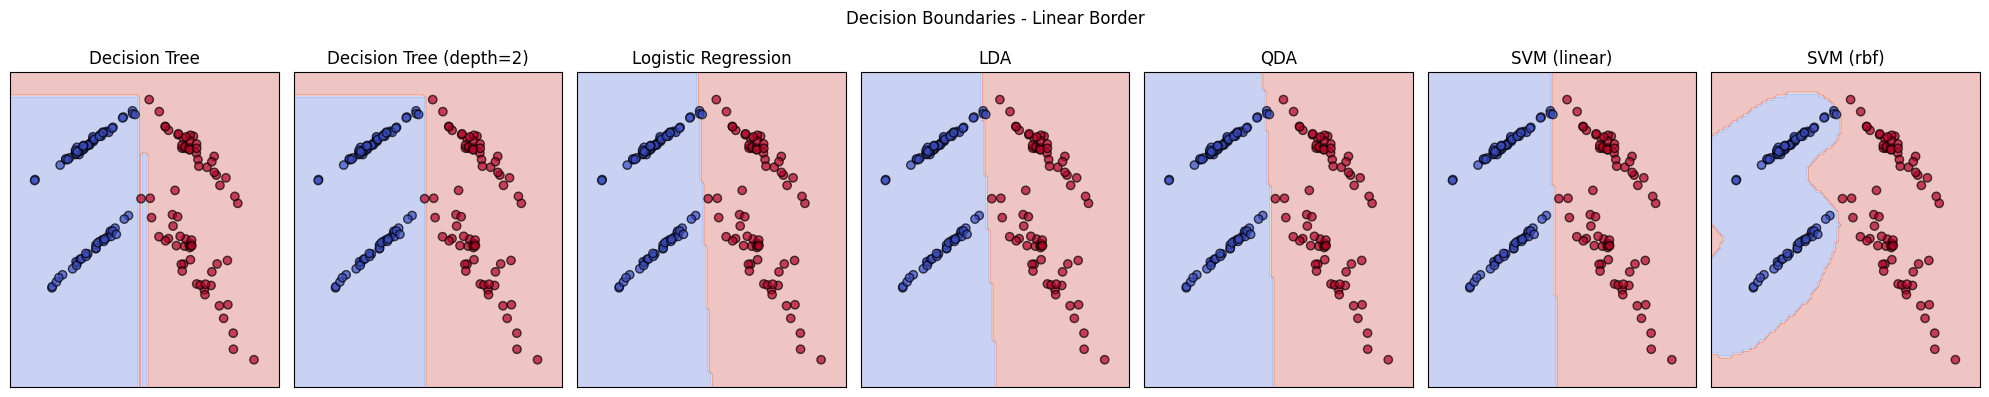

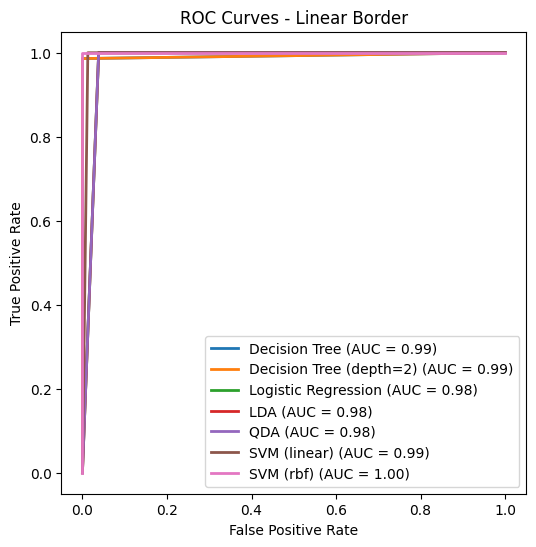

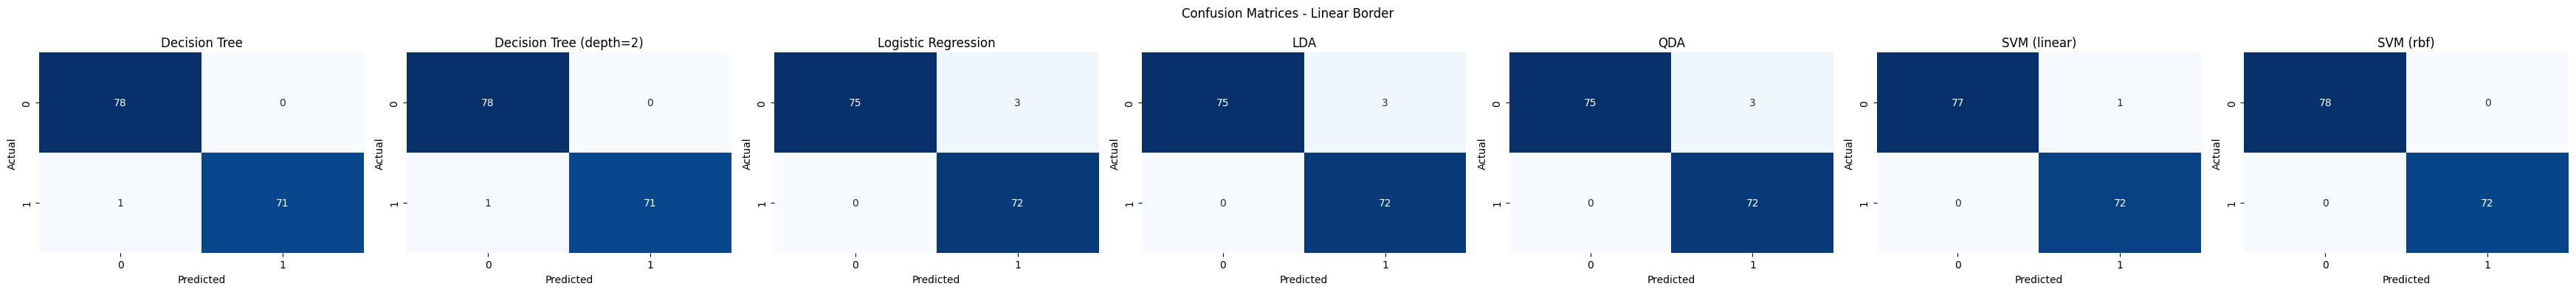


📊 Evaluating Dataset: Non-Linear Border (Cross-Validation: 5-fold)

🔍 Training Decision Tree...
 Best Params for Decision Tree: {'min_samples_split': 2}
Processing time: 0.1 sec
Accuracy: 0.9667, Precision: 0.9667, Recall: 0.9667, F1-score: 0.9667

🔍 Training Decision Tree (depth=2)...
Processing time: 0.01 sec
Accuracy: 0.7333, Precision: 0.8011, Recall: 0.7333, F1-score: 0.7150

🔍 Training Logistic Regression...
 Best Params for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Processing time: 0.05 sec
Accuracy: 0.5067, Precision: 0.5082, Recall: 0.5067, F1-score: 0.5060

🔍 Training LDA...
Processing time: 0.01 sec
Accuracy: 0.5000, Precision: 0.5012, Recall: 0.5000, F1-score: 0.4995

🔍 Training QDA...
Processing time: 0.01 sec
Accuracy: 0.9533, Precision: 0.9541, Recall: 0.9533, F1-score: 0.9533

🔍 Training SVM (linear)...
 Best Params for SVM (linear): {'C': 1}
Processing time: 0.11 sec
Accuracy: 0.6467, Precision: 0.6962, Recall: 0.6467, F1-score: 0.6180

🔍 Training SVM (rbf)..

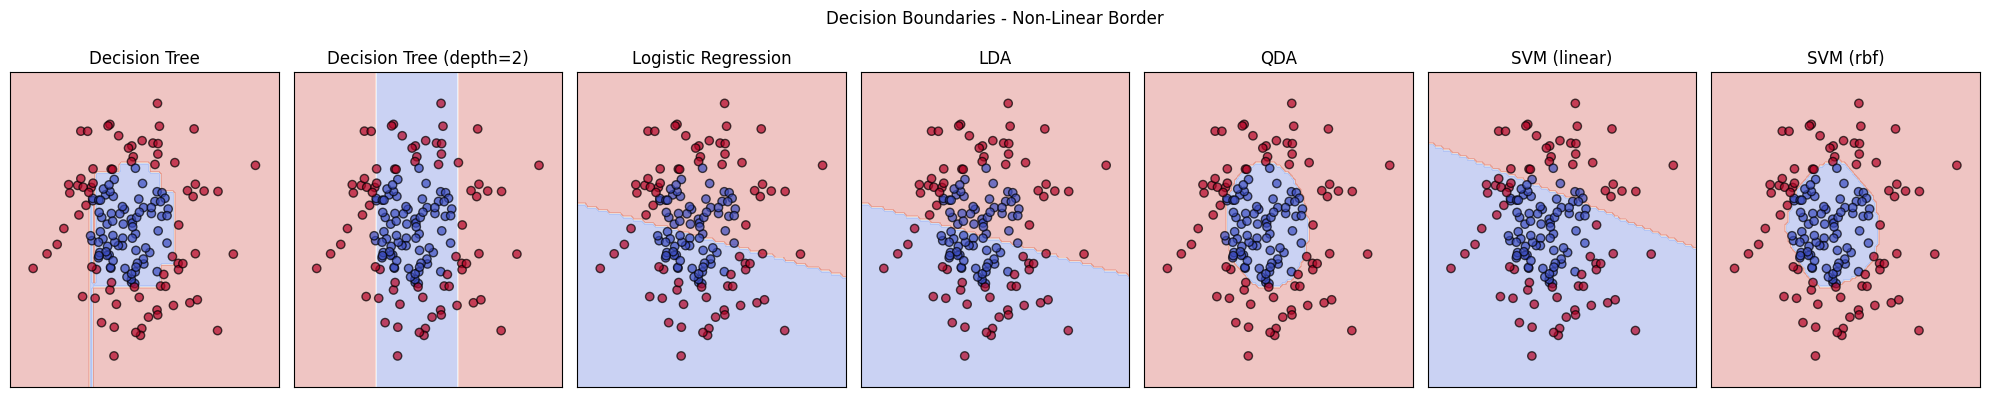

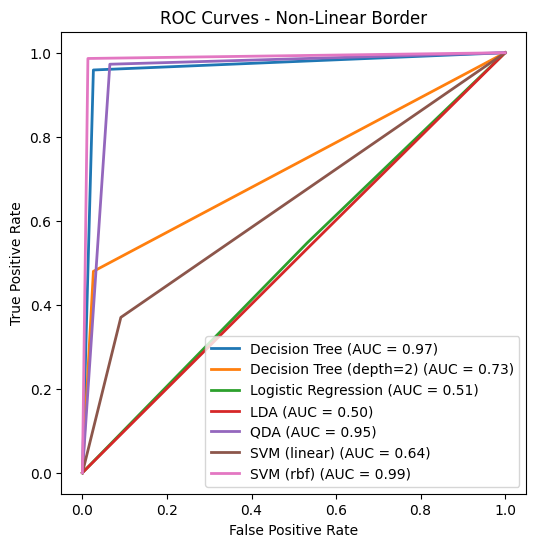

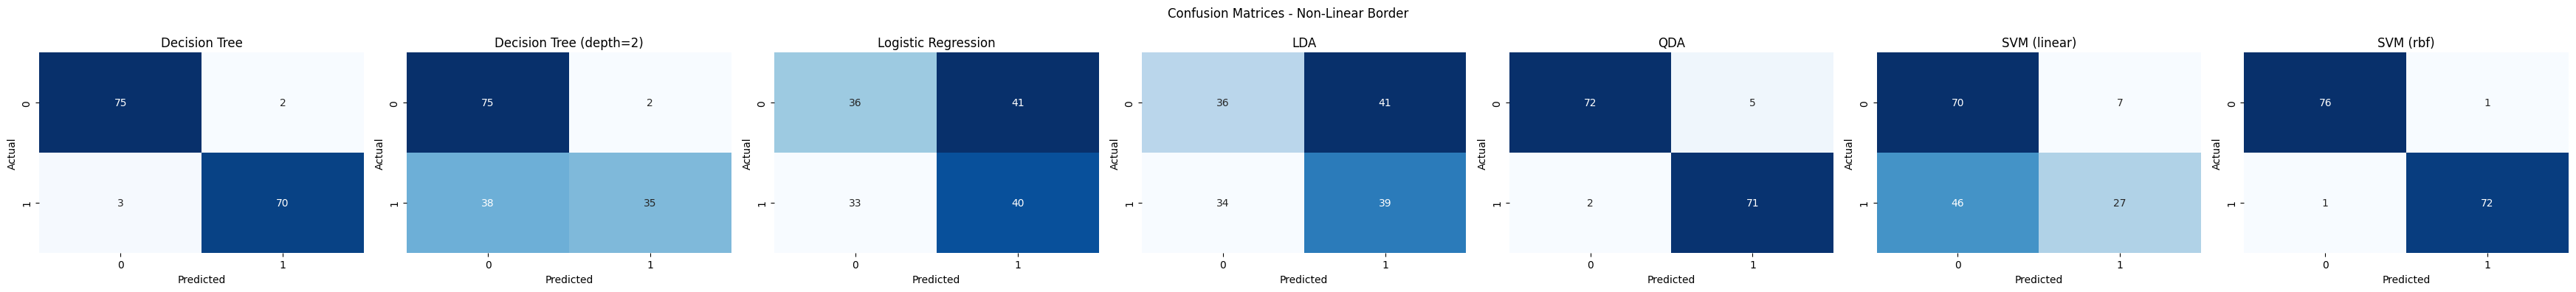

In [148]:
evaluate_dataset("Linear Border")
evaluate_dataset("Non-Linear Border")

Conclusões:
- Ao analisar um dataset com fronteiras lineares todos os algoritmos em análise tiveram facilidade em obter valores elevados em todas as métricas. Ao alterar a fronteira em análise para uma fronteira não linear, os algoritmos com uma análise linear (SVM linear, Logistic Regression e LDA) tiveram o seu desempenho prejudicado de forma mais agressiva. As decision trees mantiveram um desempenho superior aos dos algoritmos previamente mencionados, no entanto a decision tree com max depth=2 permitiu observar que datasets com fronteiras não lineares exigem que a decison tree tenha pelo menos uma max depth de 4 nós.Os algoritmos SVM rbf e QDA que quase não tiveram uma diminuição de desempenho uma vez que permitem a criação de limites de decisão não lineares.


# Bias Variance and Model Capacity

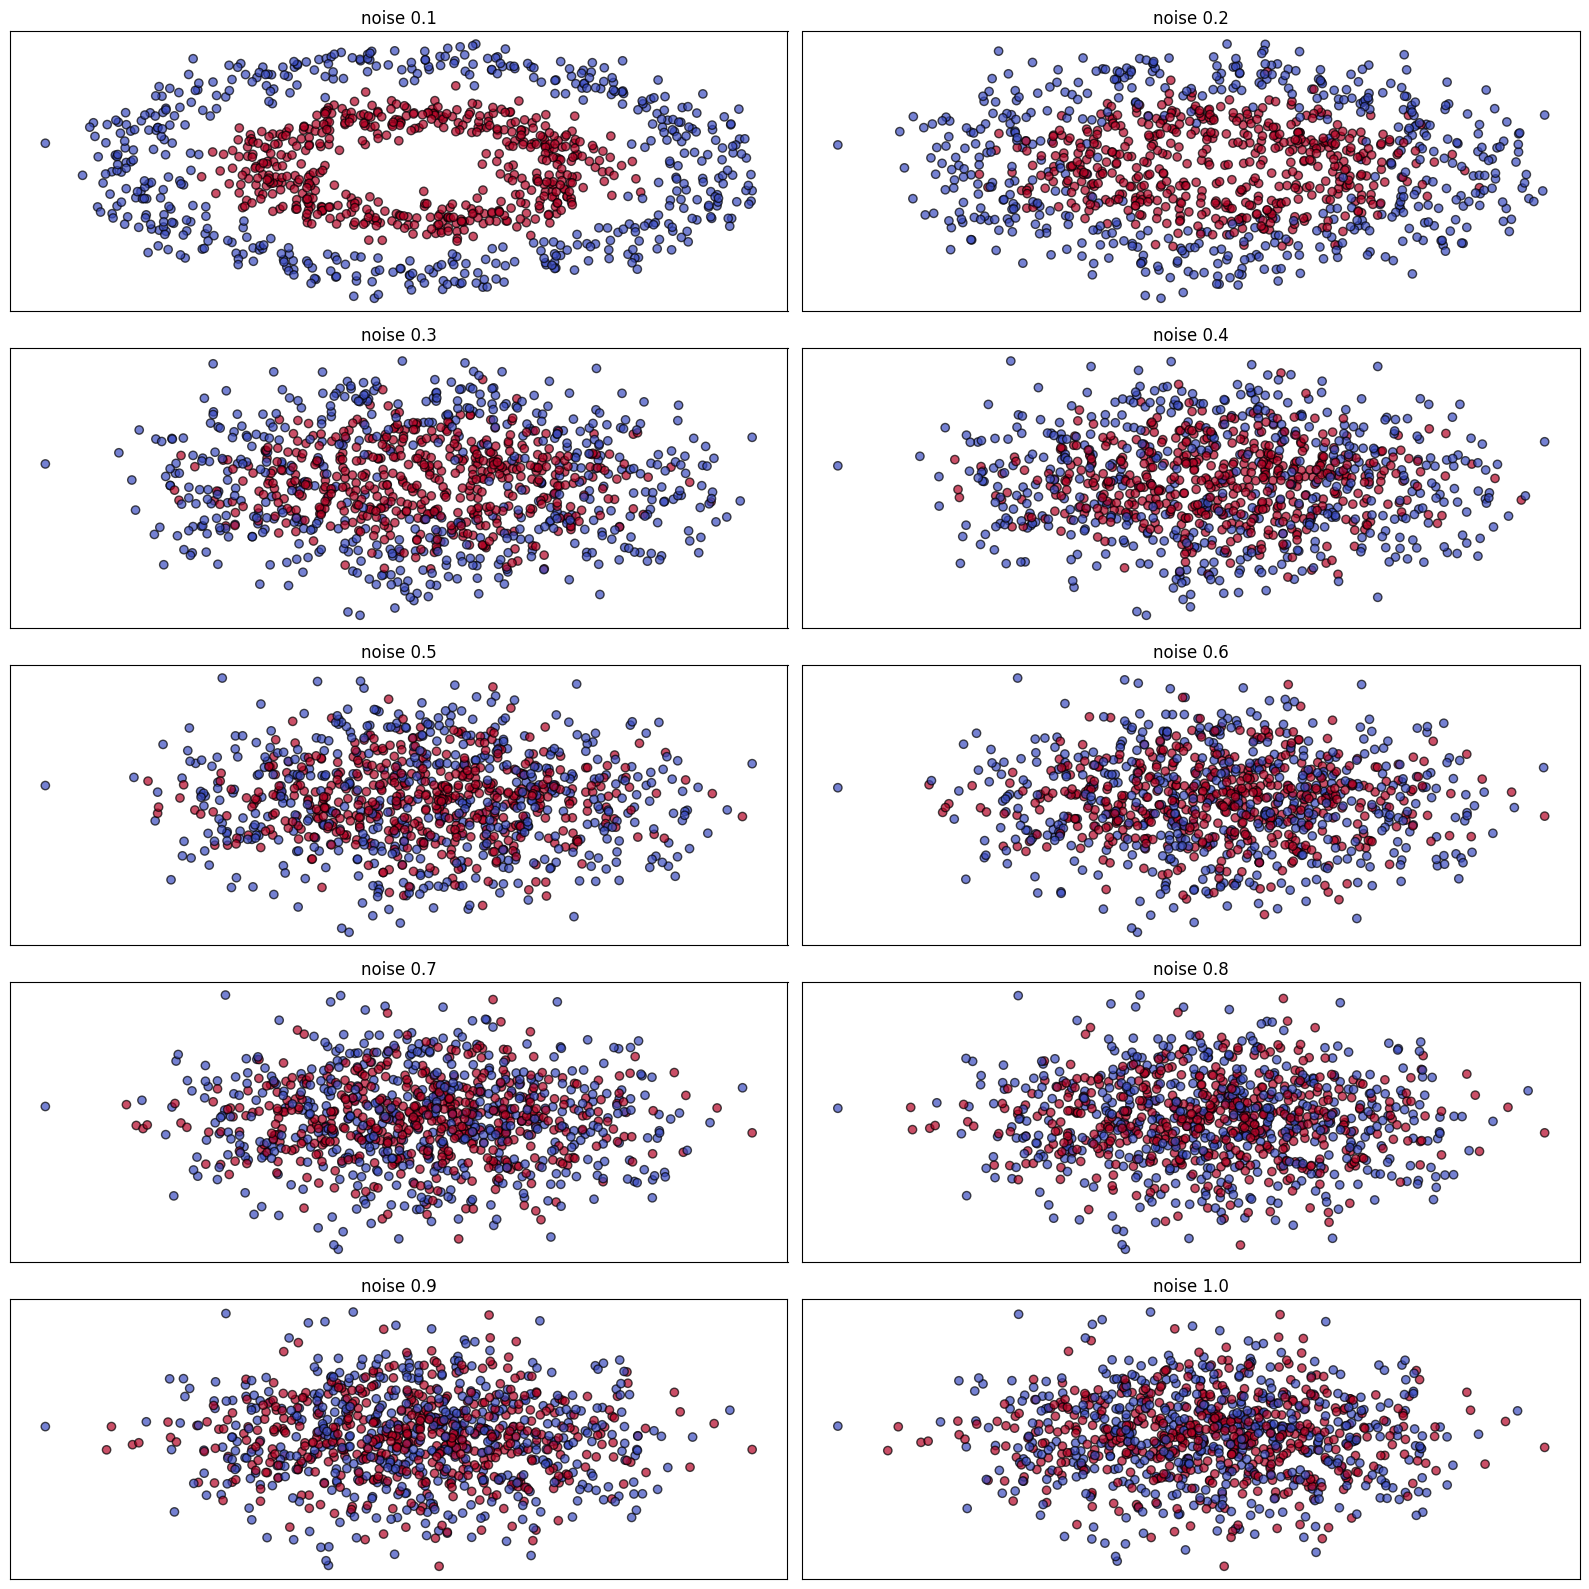

In [174]:
dataset_noise = {}
for noise_level in np.arange(0.1, 1.1, 0.1):
    X, y = make_circles(n_samples=1000, noise=noise_level, factor=0.5, random_state=42)
    dataset_noise[f"noise {noise_level:.1f}"] = (X, y)

# Plotting the datasets
fig, axes = plt.subplots(5, 2, figsize=(16, 16))
for ax, (name, (X, y)) in zip(axes.flatten(), dataset_noise.items()):
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor='k', alpha=0.7)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Split datasets into train and test
datasets_noise_train_test = {
    name: train_test_split(X, y, test_size=0.3, random_state=42)
    for name, (X, y) in dataset_noise.items()
}

In [ ]:
# List of potential ccp_alpha values for tuning
ccp_param_grid = np.linspace(0, 0.2, 50)

# Dictionary to store best ccp_alpha for each dataset
ccp = {}

# Loop through each dataset and train the models using only X_train and y_train
for name, (X_train, X_test, y_train, y_test) in datasets_noise_train_test.items():
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid={'ccp_alpha': ccp_param_grid}, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_ccp = grid_search.best_estimator_.ccp_alpha  # Extract best ccp_alpha
    ccp[name] = best_ccp  # Store it in the dictionary
    print(f"Best ccp for dataset {name} is: {best_ccp}")

Best ccp for dataset noise 0.1 is: 0.0036734693877551023
Best ccp for dataset noise 0.2 is: 0.004081632653061225
Best ccp for dataset noise 0.3 is: 0.0069387755102040816
Best ccp for dataset noise 0.4 is: 0.006530612244897959
Best ccp for dataset noise 0.5 is: 0.010612244897959184
Best ccp for dataset noise 0.6 is: 0.005714285714285714
Best ccp for dataset noise 0.7 is: 0.006530612244897959
Best ccp for dataset noise 0.8 is: 0.00816326530612245
Best ccp for dataset noise 0.9 is: 0.0032653061224489797
Best ccp for dataset noise 1.0 is: 0.005714285714285714
